#Boston Data Housing


In [27]:
#Install dependencies
!pip install fastai
!pip install nbdev
!pip install ucimlrepo

#Import libraries
import pandas as pd
import numpy as np
import fastai
from fastai.tabular.all import *
import torch
import torch.nn.functional as F
import torch.nn as nn
import pickle
import copy
import time
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from scipy import stats

#Connect to drive
#from google.colab import drive
#drive.mount('/content/drive')



#Convert and import personalised library
#!jupyter nbconvert --to python /content/drive/MyDrive/Colab\ Notebooks/utilsTFG.ipynb --output utilsTFG.py
#!cp /content/drive/MyDrive/Colab\ Notebooks/utilsTFG.py .
import sys
sys.path.append('/notebooks/utilstfg.py')
import utilstfg as utilsTFG

In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# Set seed for fastai
fastai.torch_core.set_seed(42)

# Set seed for torch
torch.manual_seed(42)
if torch.cuda.is_available():
  torch.cuda.manual_seed_all(42)

# Set seed for numpy
np.random.seed(42)

cuda


### Datos y modelos

In [29]:
#For loading and restoring models
dataset= 'bhp'
plot_dataset='BHP'

#File name in drive path
filename = "/notebooks/data/HousingData.csv"


# data (as pandas dataframes)
df = pd.read_csv(filename)

#Show the data
print(df)

# Define the categorical and continuous variables
cat_names = []
cont_names = list(df.columns)

#Remove the target from the list of features
cont_names.remove('MEDV')

#Set the target
dep_var = 'MEDV'

#Show if there is missing data
missing_values = df.isna().sum()
print(missing_values)

#Handle the missing data, filling with the mean
mis_col = ['CRIM', 'ZN', 'INDUS', 'CHAS',  'AGE', 'LSTAT']
df[mis_col] = df[mis_col].fillna(df.mean())



        CRIM    ZN  INDUS  CHAS    NOX       RM   AGE        DIS  RAD  TAX  \
0    0.00632  18.0   2.31   0.0  538.0  6575.00  65.2     4.0900    1  296   
1    0.02731   0.0   7.07   0.0  469.0  6421.00  78.9     4.9671    2  242   
2    0.02729   0.0   7.07   0.0  469.0  7185.00  61.1     4.9671    2  242   
3    0.03237   0.0   2.18   0.0  458.0  6998.00  45.8     6.0622    3  222   
4    0.06905   0.0   2.18   0.0  458.0  7147.00  54.2     6.0622    3  222   
..       ...   ...    ...   ...    ...      ...   ...        ...  ...  ...   
501  0.06263   0.0  11.93   0.0  573.0  6593.00  69.1     2.4786    1  273   
502  0.04527   0.0  11.93   0.0  573.0     6.12  76.7     2.2875    1  273   
503  0.06076   0.0  11.93   0.0  573.0  6976.00  91.0     2.1675    1  273   
504  0.10959   0.0  11.93   0.0  573.0  6794.00  89.3     2.3889    1  273   
505  0.04741   0.0  11.93   0.0  573.0     6.03   NaN  2505.0000    1  273   

     PTRATIO       B  LSTAT  MEDV  
0       15.3  396.90   4.98

MEDV       1.000000
LSTAT      0.721975
PTRATIO    0.507787
INDUS      0.478657
TAX        0.468536
RAD        0.381626
AGE        0.380223
ZN         0.365943
B          0.333461
CHAS       0.179882
RM         0.163339
NOX        0.099473
DIS        0.096858
CRIM       0.055149
dtype: float64


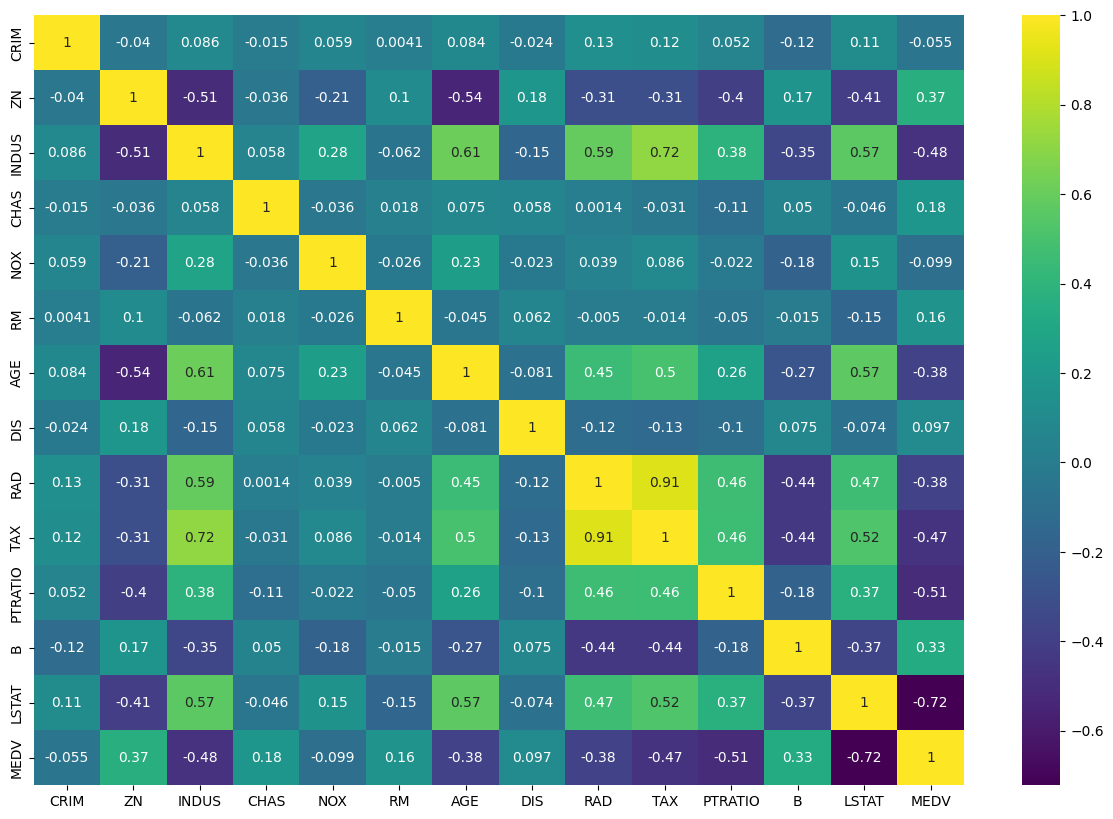

In [30]:
##Preprocessing


#Correlation of all features with the target
corr_mat = df.corr()[dep_var]
target_corr = np.abs(df.corrwith(df[dep_var]))
print(target_corr.sort_values(ascending=False))

#Correlation of features with each other
corr_matrix = df.corr()
plt.figure(figsize=(15,10))
sns.heatmap(corr_matrix,cmap="viridis", annot=True)
plt.show()


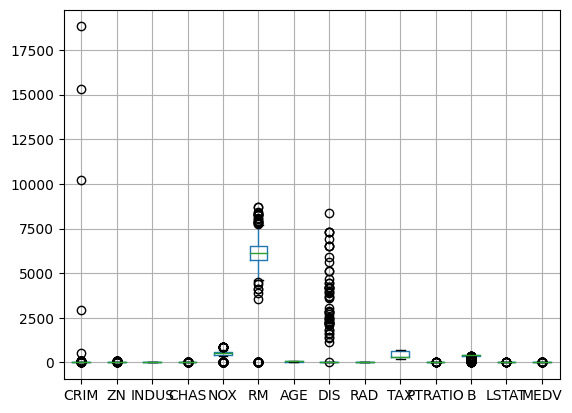

In [31]:
#Boxplot to see the range of feature values
df.boxplot()
plt.show()

In [32]:
#Drop features with low correlation with the target
df.drop(['CRIM', 'NOX', 'DIS', 'RM'], axis=1, inplace=True)
cont_names.remove('CRIM')
cont_names.remove('NOX')
cont_names.remove('DIS')
cont_names.remove('RM')

In [33]:
#Drop features with too much correlation between them

corr_matrix = df.corr()
threshold = 0.9

# Find pairs of features with correlation above the threshold
high_corr_pairs = [(i, j) for i in corr_matrix.columns for j in corr_matrix.columns if i != j and corr_matrix.loc[i, j] > threshold]

to_drop = set()


for i, j in high_corr_pairs:
    if i not in to_drop and j not in to_drop:
        # Add one of the features to the drop list
        to_drop.add(j)

# Drop the identified features from the DataFrame and the features list
df.drop(columns=to_drop, inplace=True)
cont_names = [col for col in cont_names if col not in to_drop]

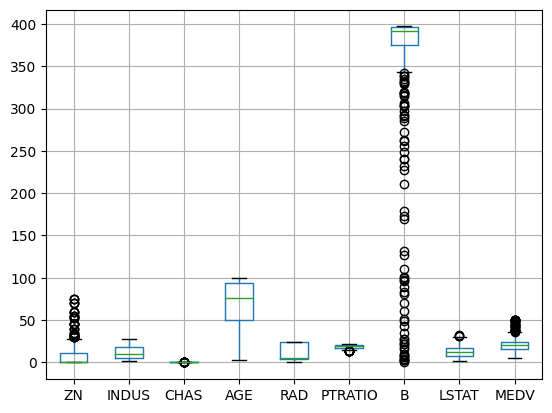

In [34]:
#Remove outliers
df_c = df.loc[(stats.zscore(df) < 3).all(axis=1)]
df_c.boxplot()
plt.show()

In [35]:
# Split indices for training, validation, and test sets
df_c = df_c.reset_index(drop=True)
train_val_split = RandomSplitter(valid_pct=0.3)(range_of(df_c))  # 70% for training/validation, 30% for testing
train_idx, val_test_idx = train_val_split

# Now split the validation/test set into validation and test sets (~20% test ~10% validation)
val_test_split = RandomSplitter(valid_pct=0.7)(val_test_idx)
val_idx, test_idx = val_test_split

# Combine all indices for the splits
splits = (train_idx, val_idx)

#Normalize
scaler = StandardScaler()
for feat in cont_names:
    df_c.loc[train_idx,feat] = scaler.fit_transform(df_c.loc[train_idx,[feat]])
    df_c.loc[val_idx,feat] = scaler.transform(df_c.loc[val_idx,[feat]])
    df_c.loc[test_idx,feat] = scaler.transform(df_c.loc[test_idx,[feat]])








# Create TabularPandas for training and validation
to = TabularPandas(
    df_c,
    procs=[Categorify],
    cat_names=cat_names,
    cont_names=cont_names,
    y_names=dep_var,
    splits=splits
)


# Create DataLoaders for training and validation
dls = to.dataloaders(bs=32, shuffle=True)

test_to = TabularPandas(
    df_c.iloc[test_idx],  # Select only the test data
    procs=[Categorify],
    cat_names=cat_names,
    cont_names=cont_names,
    y_names=dep_var
)

# Create a DataLoader for the test set. Dont shuffle to get a more objective value across computations
test_dl = test_to.dataloaders(bs=32, shuffle=False)

dls.to(device)
test_dl.to(device)

/tmp/ipykernel_462/95369750.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.65383691 -0.65383691  1.63980511 -0.65383691 -0.65383691 -0.53915481
 -0.42447271 -0.65383691 -0.88320112 -0.53915481 -0.76851901 -0.65383691
  1.63980511  1.63980511 -0.30979061 -0.65383691 -0.76851901 -0.53915481
 -0.65383691 -0.65383691  1.63980511  1.63980511 -0.65383691 -0.42447271
 -0.65383691  1.63980511  1.63980511 -0.53915481 -0.53915481 -0.19510851
 -0.53915481 -0.53915481  1.63980511 -0.42447271 -0.65383691 -0.65383691
 -0.53915481  1.63980511 -0.65383691  1.63980511 -0.88320112 -0.65383691
  1.63980511 -0.19510851 -0.30979061 -0.76851901 -0.53915481  1.63980511
 -0.53915481  1.63980511  1.63980511  1.63980511 -0.53915481 -0.65383691
 -0.99788322 -0.42447271 -0.53915481 -0.65383691 -0.76851901 -0.76851901
  1.63980511 -0.65383691 -0.76851901  1.63980511 -0.53915481 -0.19510851
  1.63980511  1.63980511 -0.88320

In [36]:
#Initialise arrays for the loops
layers = [[64], [64, 64], [ 64, 128, 256, 128, 64], [32, 64, 128, 256, 512, 1024, 512, 256, 128, 64, 32] ]
n_layers=[1,2,5,11]
optims = ['NAG', 'RMSProp', 'ADAM']
names_layer=['1 layer', '2 layers', '5 layers', '11 layers']
algs = ['SHADE', 'SHADE-ILS', 'SHADE-GD', 'SHADE-ILS-GD']
metric = ['AdjR2Sq']
init_weights = {}
for layer in n_layers:
  init_weights[layer] = {}

In [37]:
#For each number of layers initialise the model with the same parameters.
for layer in layers:
  learn = tabular_learner(dls, layers=layer, n_out=1, metrics=utilsTFG.AdjustedR2Score, loss_func=MSELossFlat())
  learn.model.apply(utilsTFG.init_weights_glorot)
  learn.to(device)
  init_weights[len(layer)] = utilsTFG.get_params_from_model(learn.model)

  print(learn.summary())

TabularModel (Input shape: 32 x 0)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 8              
BatchNorm1d                               16         True      
____________________________________________________________________________
                     32 x 64             
Linear                                    512        True      
ReLU                                                           
BatchNorm1d                               128        True      
____________________________________________________________________________
                     32 x 1              
Linear                                    65         True      
____________________________________________________________________________

Total params: 721
Total trainable params: 721
Total non-trainable params: 0

Optimizer used: <function Adam at 0x7f91b9476160>
Loss function: FlattenedLoss of MSELoss()

Callbacks:
  - TrainEvalCallback
  - CastToTensor
  -

TabularModel (Input shape: 32 x 0)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 8              
BatchNorm1d                               16         True      
____________________________________________________________________________
                     32 x 64             
Linear                                    512        True      
ReLU                                                           
BatchNorm1d                               128        True      
Linear                                    4096       True      
ReLU                                                           
BatchNorm1d                               128        True      
____________________________________________________________________________
                     32 x 1              
Linear                                    65         True      
____________________________________________________________________________

Total params: 4,945
Total train

TabularModel (Input shape: 32 x 0)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 8              
BatchNorm1d                               16         True      
____________________________________________________________________________
                     32 x 64             
Linear                                    512        True      
ReLU                                                           
BatchNorm1d                               128        True      
____________________________________________________________________________
                     32 x 128            
Linear                                    8192       True      
ReLU                                                           
BatchNorm1d                               256        True      
____________________________________________________________________________
                     32 x 256            
Linear                                    32768      T

TabularModel (Input shape: 32 x 0)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 8              
BatchNorm1d                               16         True      
____________________________________________________________________________
                     32 x 32             
Linear                                    256        True      
ReLU                                                           
BatchNorm1d                               64         True      
____________________________________________________________________________
                     32 x 64             
Linear                                    2048       True      
ReLU                                                           
BatchNorm1d                               128        True      
____________________________________________________________________________
                     32 x 128            
Linear                                    8192       T

## Gradient Descent

In [38]:
# Define the optimizers
NAG = partial(OptimWrapper, opt=torch.optim.SGD, momentum=0.9, nesterov=True)
RMSProp = partial(OptimWrapper, opt=torch.optim.RMSprop)
ADAM = partial(OptimWrapper, opt=torch.optim.Adam)
optims2 = [NAG, RMSProp, ADAM]

# Initialize the learners dictionary
learners = {}
time_gd = {}
epochs=20

# Iterate over the optimizers and layers to create learners
for opt, opt2 in zip(optims, optims2):
    learners[opt] = {}  # Initialize the dictionary for this optimizer
    time_gd[opt] = {}
    for layer in layers:
        learners[opt][len(layer)] = tabular_learner(dls=dls, layers=layer, n_out=1, loss_func = MSELossFlat(), metrics=utilsTFG.AdjustedR2Score, opt_func=opt2, cbs=[SaveModelCallback()])
        learners[opt][len(layer)].to(device)
        learners[opt][len(layer)].model.to(device)
        utilsTFG.set_params_to_model(init_weights[len(layer)], learners[opt][len(layer)].model)


In [39]:
#To check if the models have the same initial parameters
for layer in n_layers:
  if utilsTFG.compare_models(learners['NAG'][layer], learners['RMSProp'][layer]) and utilsTFG.compare_models(learners['NAG'][layer], learners['ADAM'][layer]) and utilsTFG.compare_models(learners['ADAM'][layer], learners['RMSProp'][layer]):
    print(f"Mismos parámetros en capa {layer}.")
  else:
    print("Distintos parámetros.")


Mismos parámetros en capa 1.
Mismos parámetros en capa 2.
Mismos parámetros en capa 5.
Mismos parámetros en capa 11.


### Nesterov

Better model found at epoch 0 with valid_loss value: 473.798095703125.
Better model found at epoch 1 with valid_loss value: 405.1255798339844.
Better model found at epoch 2 with valid_loss value: 242.7284698486328.
Better model found at epoch 3 with valid_loss value: 41.7409553527832.
Better model found at epoch 4 with valid_loss value: 25.548276901245117.
Better model found at epoch 5 with valid_loss value: 21.15668487548828.
Better model found at epoch 6 with valid_loss value: 18.8467960357666.
Better model found at epoch 7 with valid_loss value: 15.320569038391113.
Better model found at epoch 15 with valid_loss value: 14.256790161132812.
Better model found at epoch 16 with valid_loss value: 13.986279487609863.
Better model found at epoch 17 with valid_loss value: 13.861056327819824.
Better model found at epoch 19 with valid_loss value: 13.718076705932617.


Better model found at epoch 0 with valid_loss value: 485.814697265625.
Better model found at epoch 1 with valid_loss value: 450.99725341796875.
Better model found at epoch 2 with valid_loss value: 354.8002014160156.
Better model found at epoch 3 with valid_loss value: 192.06570434570312.
Better model found at epoch 4 with valid_loss value: 115.05601501464844.
Better model found at epoch 5 with valid_loss value: 24.66090965270996.
Better model found at epoch 6 with valid_loss value: 17.71921157836914.
Better model found at epoch 7 with valid_loss value: 16.961938858032227.
Better model found at epoch 10 with valid_loss value: 15.562887191772461.
Better model found at epoch 13 with valid_loss value: 14.888958930969238.
Better model found at epoch 15 with valid_loss value: 14.803201675415039.
Better model found at epoch 17 with valid_loss value: 13.885391235351562.
Better model found at epoch 18 with valid_loss value: 12.0686616897583.


Better model found at epoch 0 with valid_loss value: 460.16259765625.
Better model found at epoch 1 with valid_loss value: 402.30389404296875.
Better model found at epoch 2 with valid_loss value: 268.647705078125.
Better model found at epoch 3 with valid_loss value: 96.10527801513672.
Better model found at epoch 4 with valid_loss value: 15.923591613769531.
Better model found at epoch 7 with valid_loss value: 13.71386432647705.
Better model found at epoch 10 with valid_loss value: 12.776045799255371.
Better model found at epoch 14 with valid_loss value: 12.46044921875.
Better model found at epoch 17 with valid_loss value: 11.511585235595703.


Better model found at epoch 0 with valid_loss value: 496.65081787109375.
Better model found at epoch 1 with valid_loss value: 442.6402282714844.
Better model found at epoch 2 with valid_loss value: 140.80838012695312.
Better model found at epoch 3 with valid_loss value: 107.10286712646484.
Better model found at epoch 4 with valid_loss value: 39.01736831665039.
Better model found at epoch 5 with valid_loss value: 25.385828018188477.
Better model found at epoch 6 with valid_loss value: 15.42225170135498.


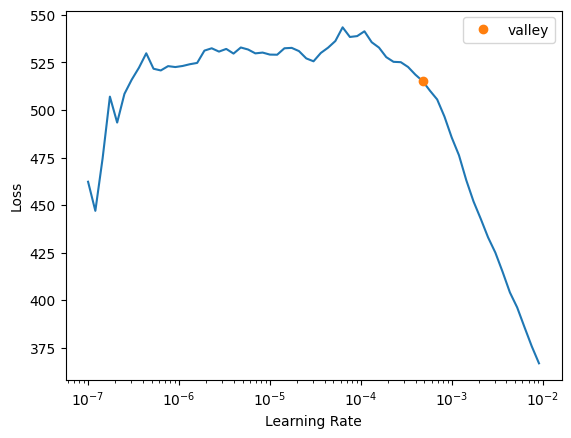

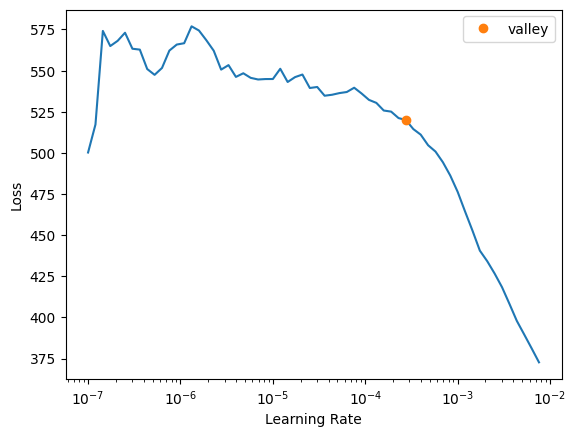

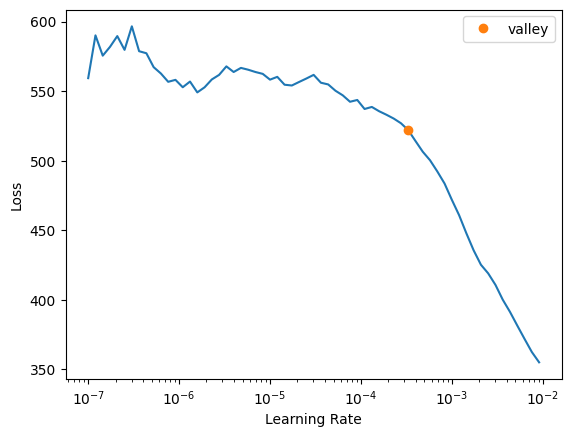

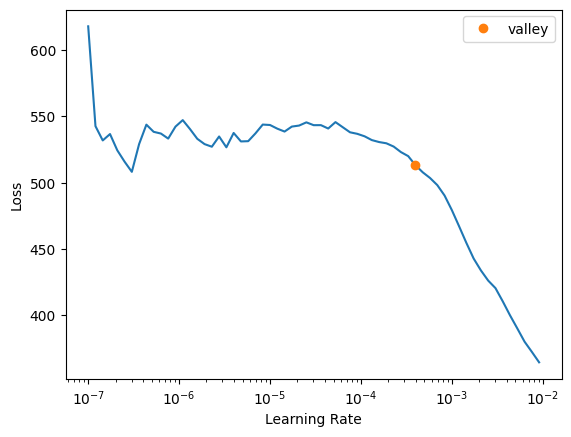

In [40]:
#Run the training and measure the time for each layer
for layer, learner in learners['NAG'].items():
  lr=learner.lr_find()
  start = time.perf_counter()
  learner.fit_one_cycle(epochs, lr)
  end = time.perf_counter()
  time_gd['NAG'][layer] = end-start



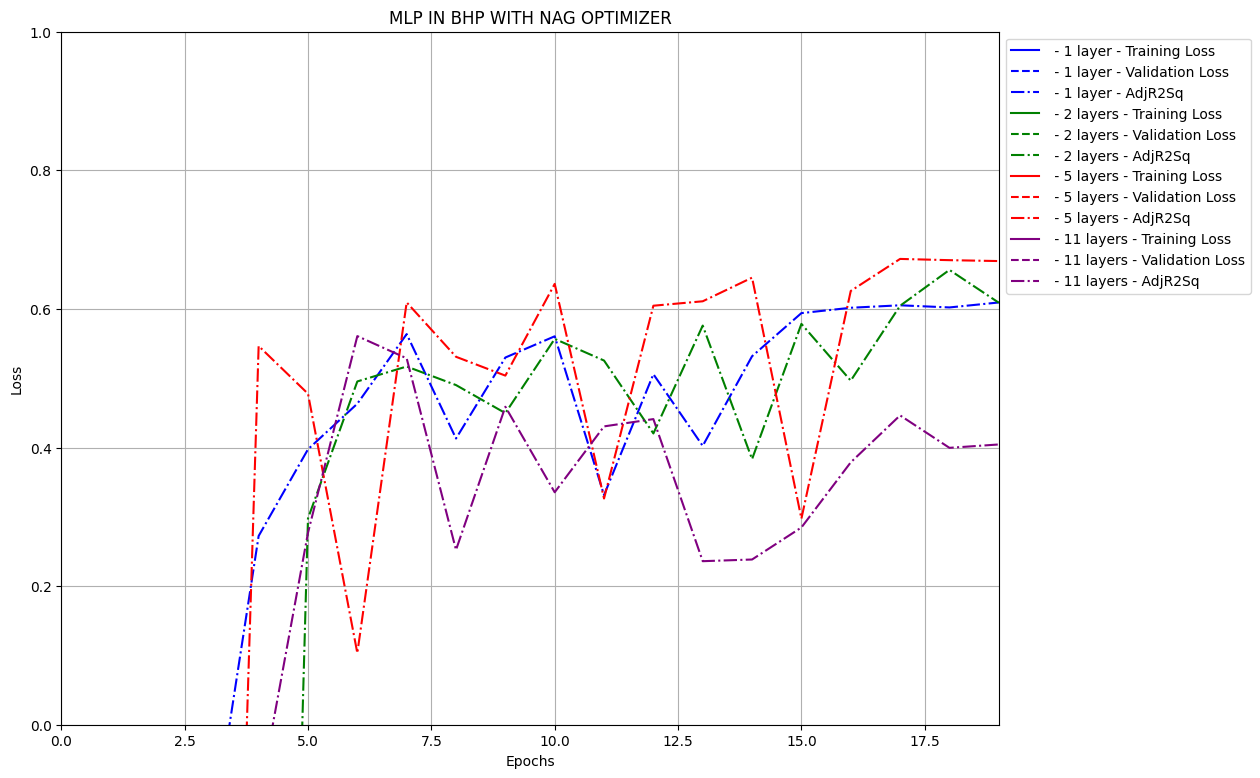

In [41]:
#Plot the grafic for all layers combined
utilsTFG.plot_learners_training(learners['NAG'].values(), title=f'MLP IN {plot_dataset} WITH NAG OPTIMIZER', names=names_layer, metric=metric)

### RMSProp

Better model found at epoch 0 with valid_loss value: 403.75335693359375.
Better model found at epoch 1 with valid_loss value: 29.089996337890625.
Better model found at epoch 4 with valid_loss value: 28.188030242919922.
Better model found at epoch 6 with valid_loss value: 19.774078369140625.
Better model found at epoch 8 with valid_loss value: 17.357318878173828.
Better model found at epoch 9 with valid_loss value: 17.05281639099121.
Better model found at epoch 14 with valid_loss value: 16.516368865966797.
Better model found at epoch 15 with valid_loss value: 15.017305374145508.
Better model found at epoch 16 with valid_loss value: 11.407025337219238.


Better model found at epoch 0 with valid_loss value: 354.8991394042969.
Better model found at epoch 1 with valid_loss value: 226.74520874023438.
Better model found at epoch 2 with valid_loss value: 139.07369995117188.
Better model found at epoch 5 with valid_loss value: 13.894848823547363.
Better model found at epoch 12 with valid_loss value: 11.678831100463867.
Better model found at epoch 16 with valid_loss value: 11.20160961151123.
Better model found at epoch 19 with valid_loss value: 10.089895248413086.


Better model found at epoch 0 with valid_loss value: 429.91766357421875.
Better model found at epoch 2 with valid_loss value: 96.92237854003906.
Better model found at epoch 4 with valid_loss value: 30.196121215820312.
Better model found at epoch 5 with valid_loss value: 16.7636775970459.
Better model found at epoch 6 with valid_loss value: 15.936755180358887.
Better model found at epoch 11 with valid_loss value: 15.262507438659668.
Better model found at epoch 19 with valid_loss value: 15.259658813476562.


Better model found at epoch 0 with valid_loss value: 357.4012756347656.
Better model found at epoch 4 with valid_loss value: 45.58616638183594.
Better model found at epoch 5 with valid_loss value: 27.280582427978516.
Better model found at epoch 6 with valid_loss value: 15.215794563293457.
Better model found at epoch 7 with valid_loss value: 13.288930892944336.


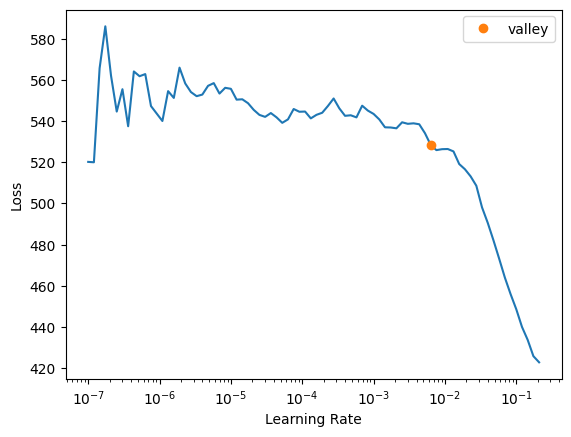

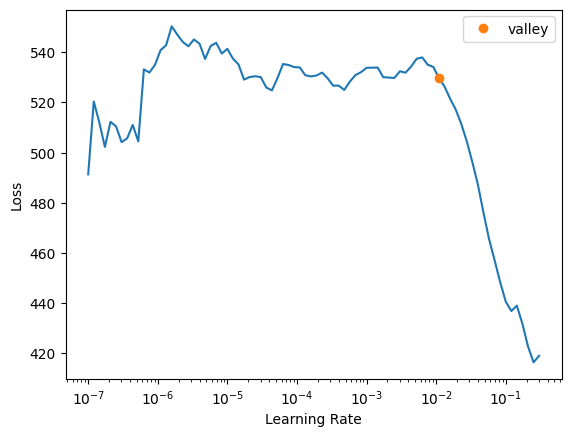

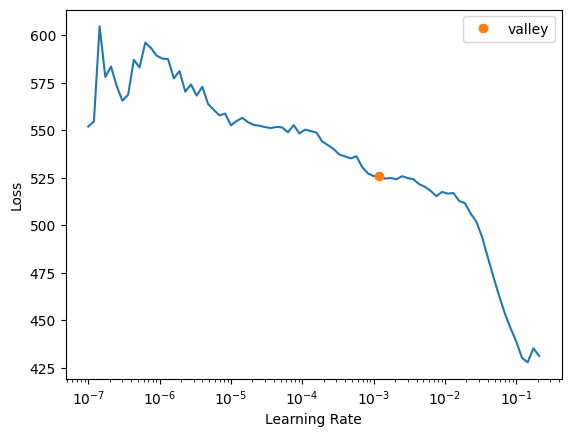

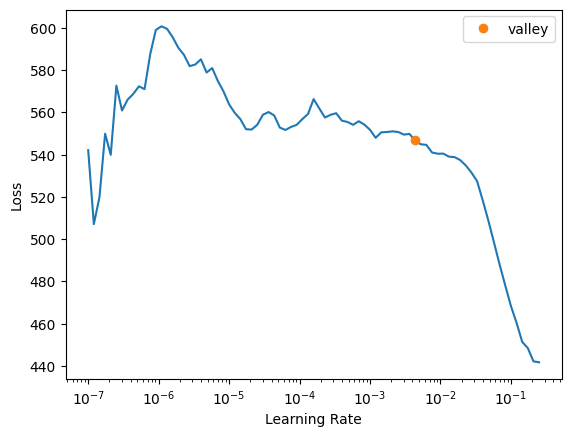

In [42]:
#Run the training and measure the time for each layer
for layer, learner in learners['RMSProp'].items():
  lr=learner.lr_find()
  start = time.perf_counter()
  learner.fit_one_cycle(epochs, lr)
  end = time.perf_counter()
  time_gd['RMSProp'][layer] = end-start


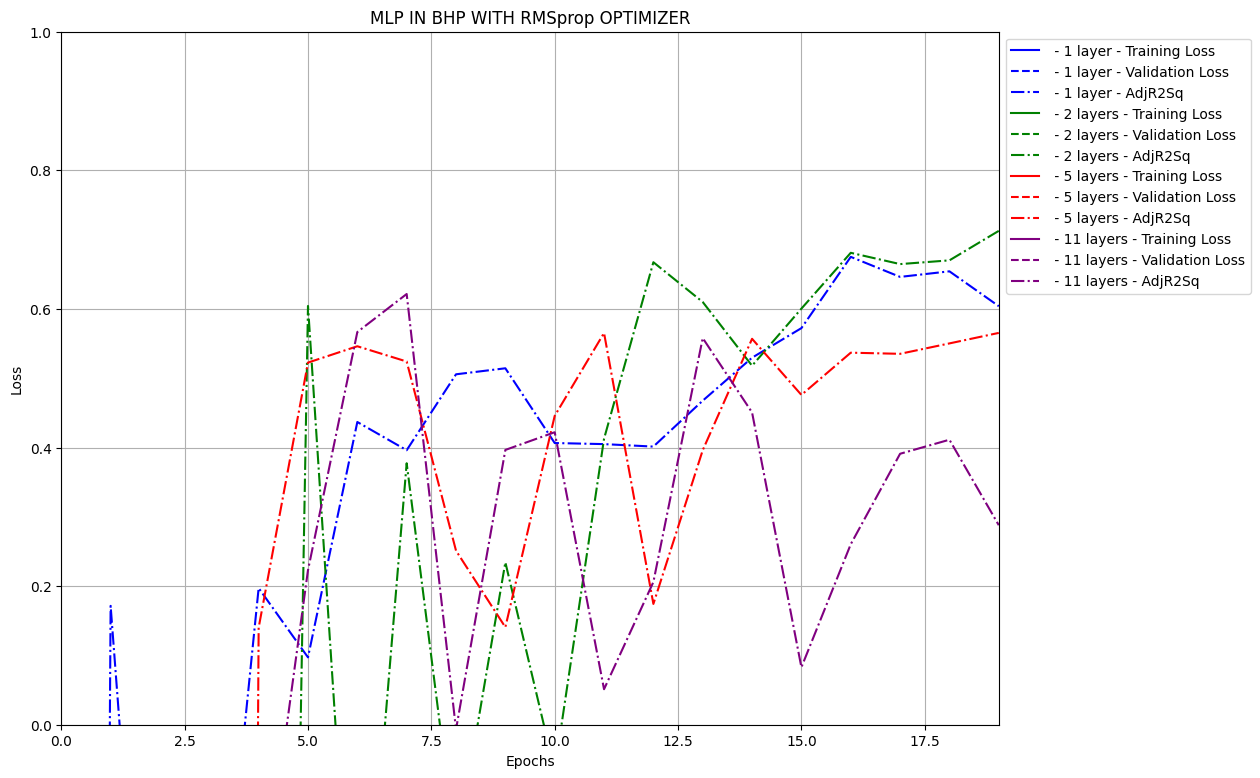

In [43]:
#Plot the grafic for all layers combined
utilsTFG.plot_learners_training(learners['RMSProp'].values(), title=f'MLP IN {plot_dataset} WITH RMSprop OPTIMIZER', names=names_layer, metric=metric)

### Adam

Better model found at epoch 0 with valid_loss value: 473.1705017089844.
Better model found at epoch 1 with valid_loss value: 429.4609375.
Better model found at epoch 2 with valid_loss value: 348.4267578125.
Better model found at epoch 3 with valid_loss value: 198.20297241210938.
Better model found at epoch 4 with valid_loss value: 26.34714698791504.
Better model found at epoch 5 with valid_loss value: 20.22232437133789.
Better model found at epoch 6 with valid_loss value: 17.76913833618164.
Better model found at epoch 9 with valid_loss value: 14.90648078918457.
Better model found at epoch 10 with valid_loss value: 13.775433540344238.


Better model found at epoch 0 with valid_loss value: 470.6590881347656.
Better model found at epoch 1 with valid_loss value: 414.15509033203125.
Better model found at epoch 2 with valid_loss value: 242.15115356445312.
Better model found at epoch 3 with valid_loss value: 16.34511947631836.
Better model found at epoch 6 with valid_loss value: 15.775354385375977.
Better model found at epoch 12 with valid_loss value: 14.442285537719727.
Better model found at epoch 13 with valid_loss value: 12.462761878967285.


Better model found at epoch 0 with valid_loss value: 458.66400146484375.
Better model found at epoch 1 with valid_loss value: 369.35992431640625.
Better model found at epoch 4 with valid_loss value: 347.3416442871094.
Better model found at epoch 5 with valid_loss value: 40.0637092590332.
Better model found at epoch 6 with valid_loss value: 27.33782386779785.
Better model found at epoch 7 with valid_loss value: 25.581140518188477.
Better model found at epoch 8 with valid_loss value: 23.8890380859375.
Better model found at epoch 11 with valid_loss value: 15.961868286132812.
Better model found at epoch 12 with valid_loss value: 14.75910472869873.
Better model found at epoch 16 with valid_loss value: 14.339510917663574.
Better model found at epoch 17 with valid_loss value: 14.053443908691406.


Better model found at epoch 0 with valid_loss value: 494.16510009765625.
Better model found at epoch 1 with valid_loss value: 402.9977111816406.
Better model found at epoch 3 with valid_loss value: 240.572509765625.
Better model found at epoch 5 with valid_loss value: 188.2916259765625.
Better model found at epoch 6 with valid_loss value: 83.02899932861328.
Better model found at epoch 7 with valid_loss value: 23.792030334472656.
Better model found at epoch 10 with valid_loss value: 21.040437698364258.
Better model found at epoch 11 with valid_loss value: 19.919116973876953.
Better model found at epoch 13 with valid_loss value: 14.910774230957031.
Better model found at epoch 14 with valid_loss value: 12.338102340698242.


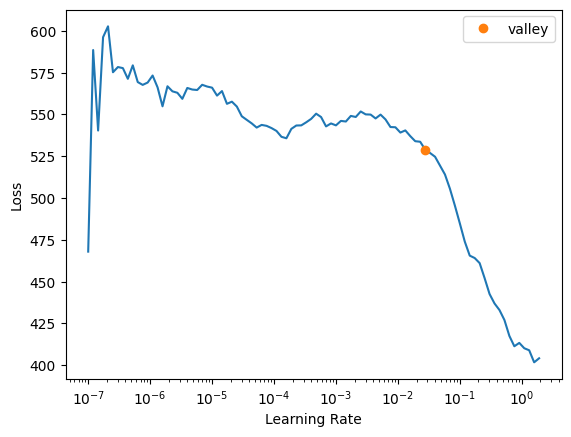

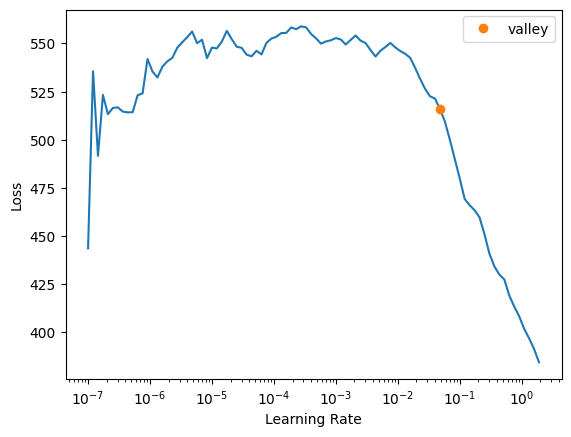

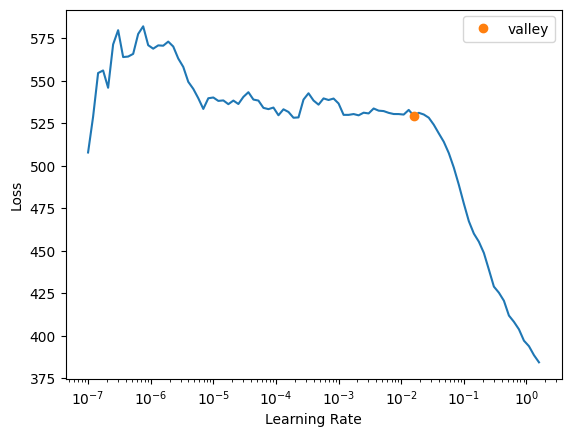

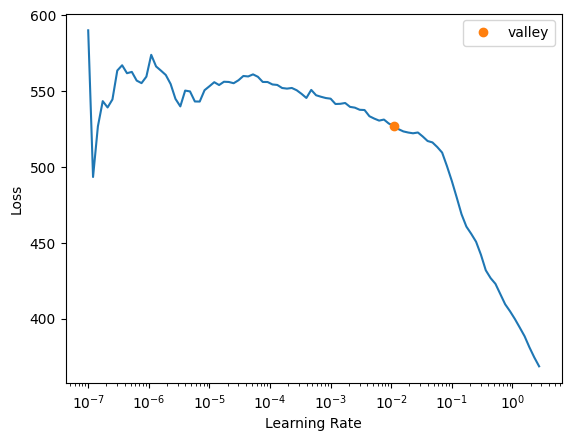

In [44]:
#Run the training and measure the time for each layer
for layer, learner in learners['ADAM'].items():
  lr=learner.lr_find()
  start = time.perf_counter()
  learner.fit_one_cycle(epochs, lr)
  end = time.perf_counter()
  time_gd['ADAM'][layer] = end-start


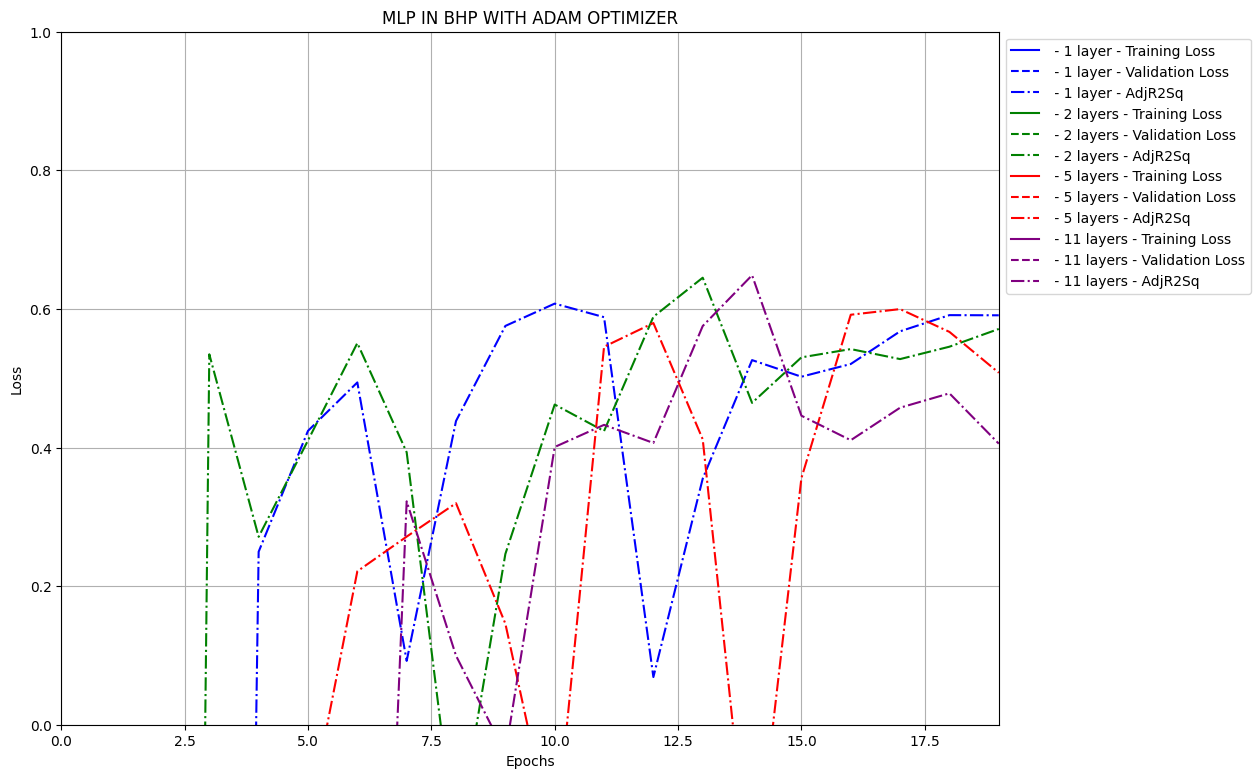

In [45]:
#Plot the grafic for all layers combined
utilsTFG.plot_learners_training(learners['ADAM'].values(), title=f'MLP IN {plot_dataset} WITH ADAM OPTIMIZER', lim=1, names=names_layer, metric=metric)

### Save or Load models

In [46]:
#Save learner with their losses and metrics
for optim in optims:
  for layer in n_layers:
    file_path = f'/notebooks/saved_models/learner_{dataset}_{layer}_{optim}.pkl'
    with open(file_path, 'wb') as f:
        pickle.dump({'learner': learners[optim][layer], 'recorder_values': learners[optim][layer].recorder.values}, f)


In [47]:
#Load learner with their losses and metrics
for optim in optims:
  for layer in n_layers:
    file_path = f'/notebooks/saved_models/learner_{dataset}_{layer}_{optim}.pkl'
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    learners[optim][layer], learners[optim][layer].recorder.values = data['learner'], data['recorder_values']

### Comparative per layers

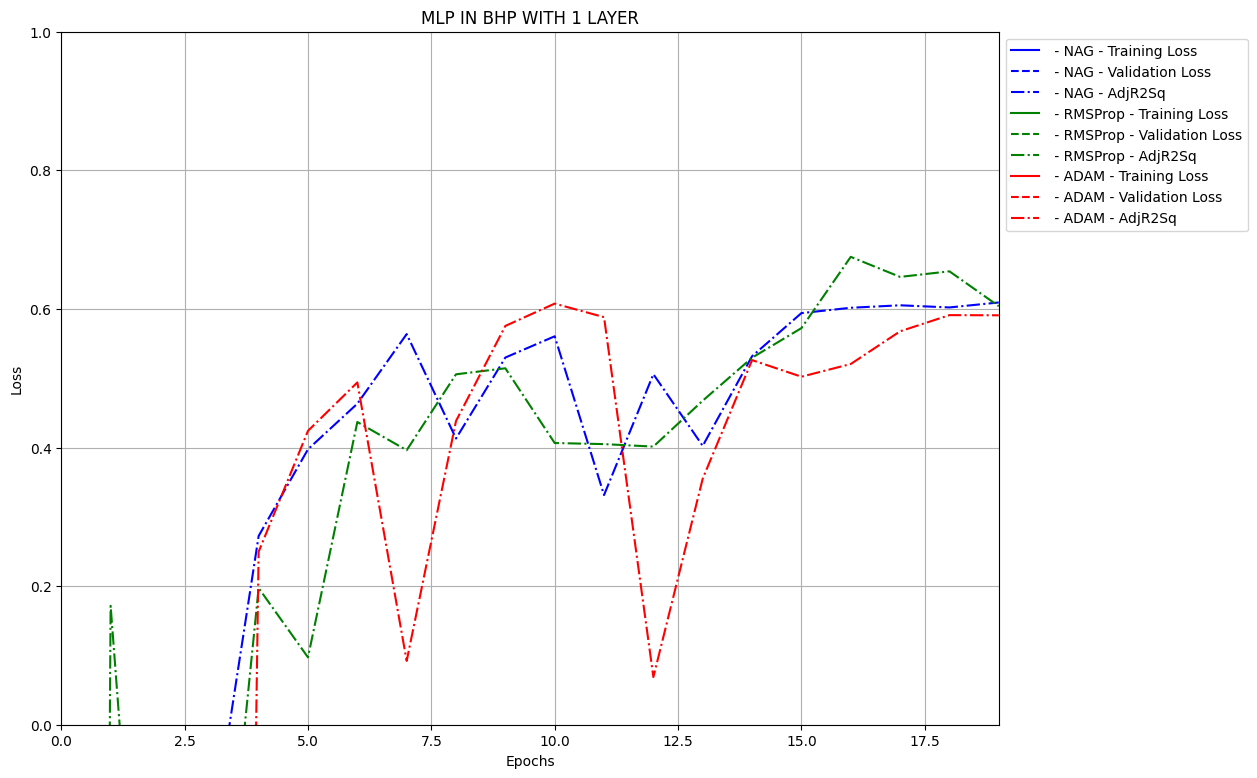

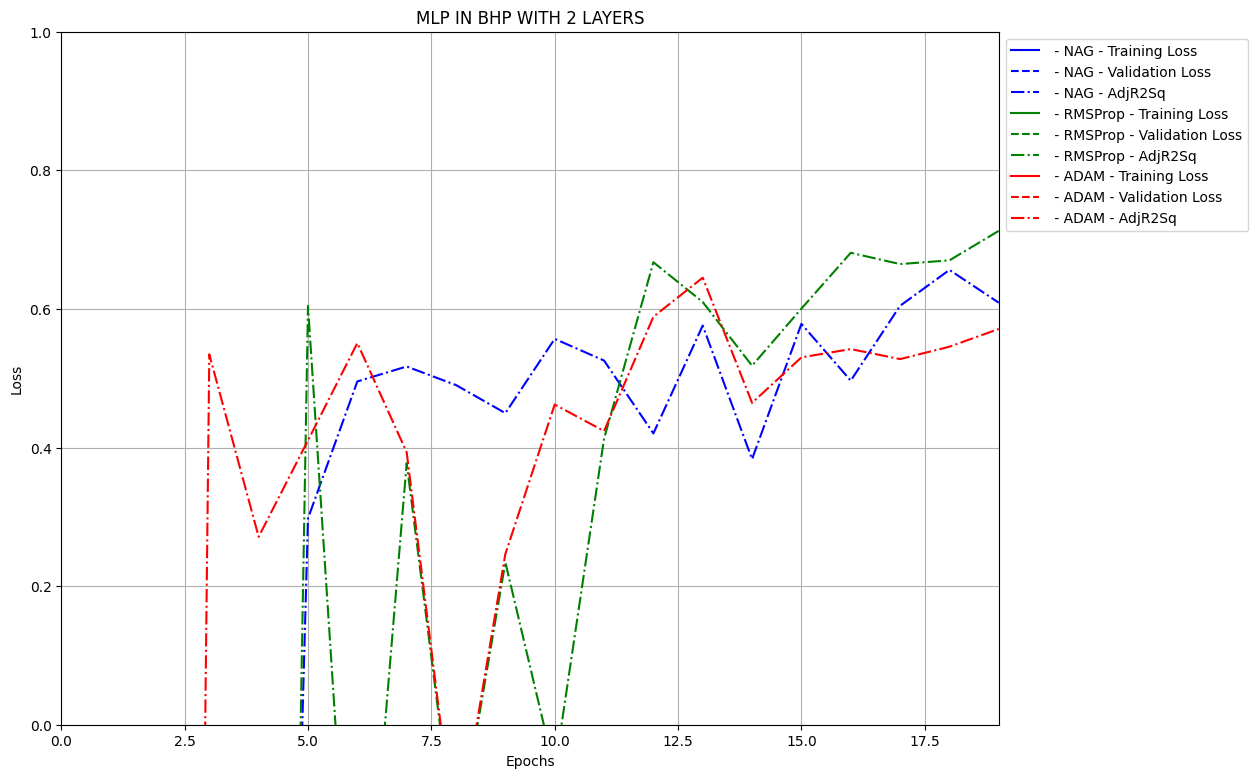

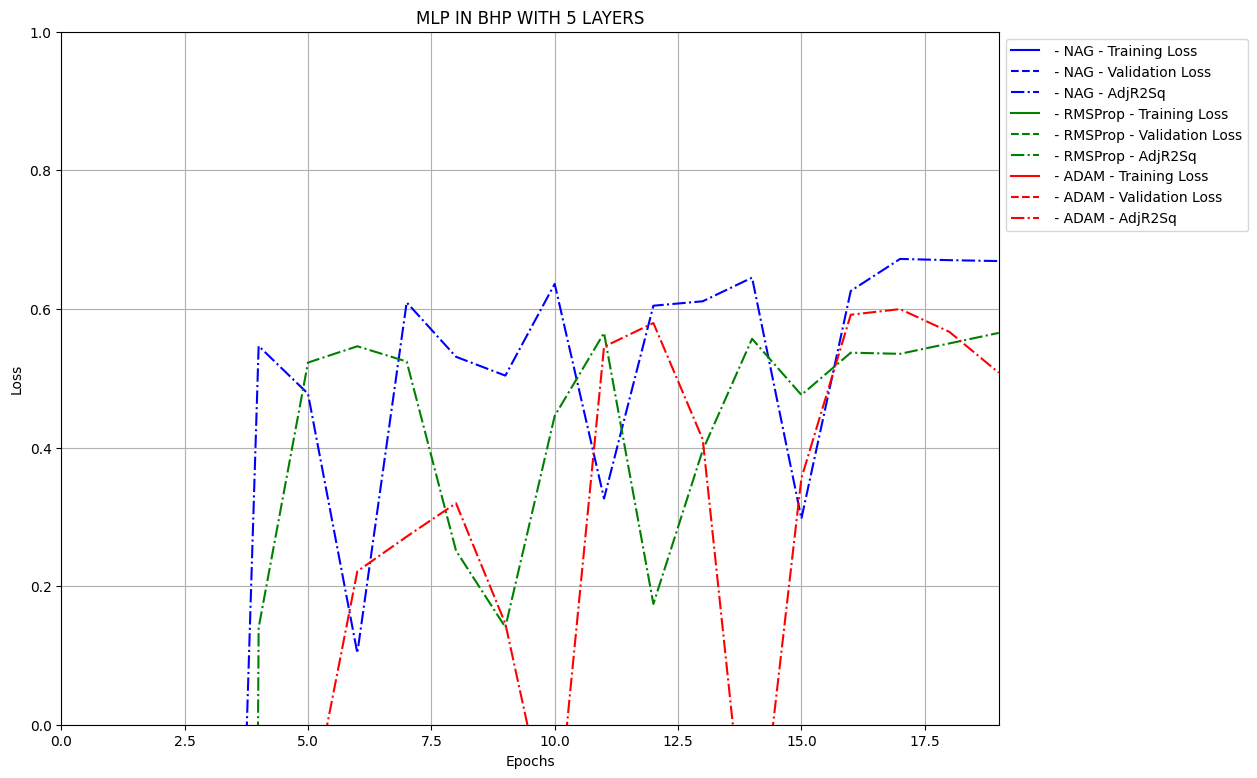

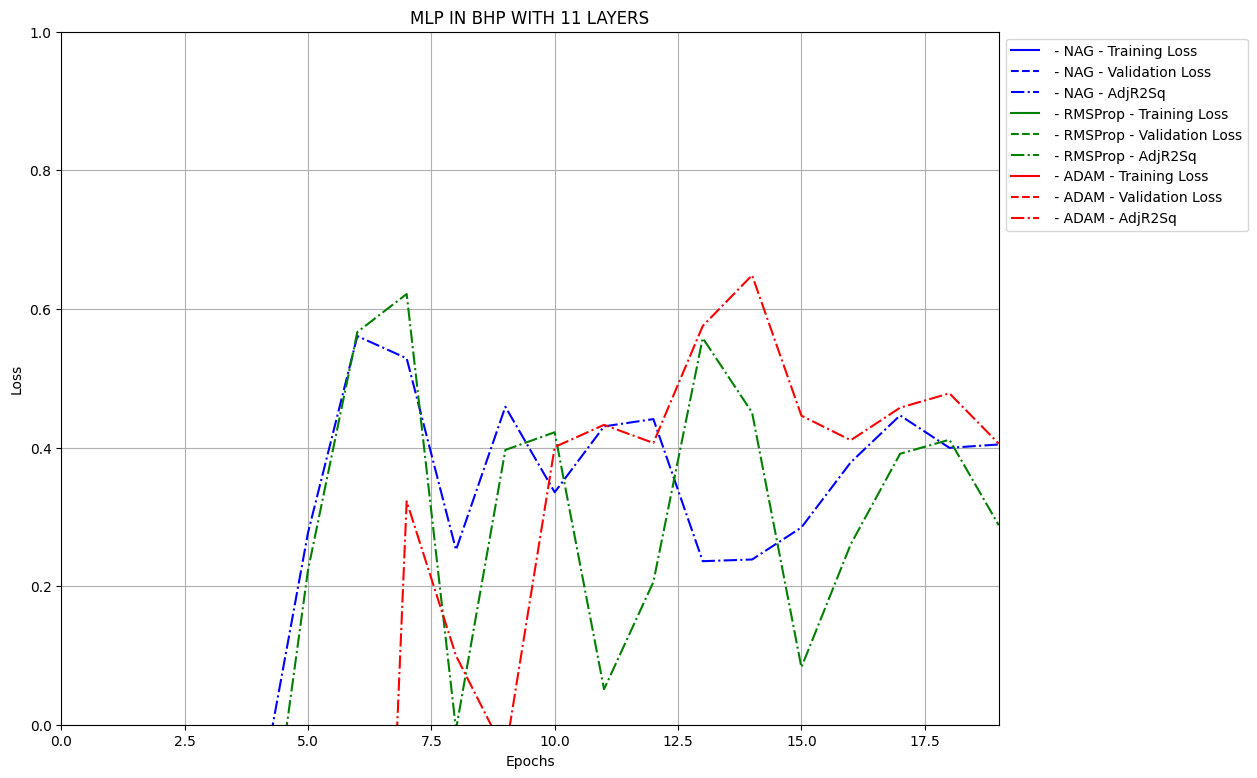

In [48]:
#Compare the three optimizers for each layer

learners_1_layer = [learners['NAG'][1], learners['RMSProp'][1], learners['ADAM'][1]]
learners_2_layers = [learners['NAG'][2], learners['RMSProp'][2], learners['ADAM'][2]]
learners_5_layers = [learners['NAG'][5], learners['RMSProp'][5], learners['ADAM'][5]]
learners_11_layers = [learners['NAG'][11], learners['RMSProp'][11], learners['ADAM'][11]]

names=['NAG', 'RMSProp', 'ADAM']
utilsTFG.plot_learners_training(learners_1_layer, title=f'MLP IN {plot_dataset} WITH 1 LAYER', names=names, metric=metric)
utilsTFG.plot_learners_training(learners_2_layers, title=f'MLP IN {plot_dataset} WITH 2 LAYERS', names=names, metric=metric)
utilsTFG.plot_learners_training(learners_5_layers, title=f'MLP IN {plot_dataset} WITH 5 LAYERS', names=names, metric=metric)
utilsTFG.plot_learners_training(learners_11_layers, title=f'MLP IN {plot_dataset} WITH 11 LAYERS', names=names, metric=metric)

### Generalization

In [49]:
#Run the model in the test set
for optim in optims:
  for layer in n_layers:
    #Run the model with optimizer optim and n_layers layer the test set in evaluation mode
    learners[optim][layer].model.eval()
    learners[optim][layer].eval()
    preds, targs = learners[optim][layer].get_preds(dl=test_dl)
    targs = targs.long().squeeze()



    #Calculate Adjusted R2 Square

    r2 = utilsTFG.adjusted_r2_score(preds.squeeze(), targs)

    #Calculate loss
    loss = utilsTFG.err_param_w_model(learners[optim][layer].model, test_dl, mode = 'test', task='reg')


    print(f"Optimizer: {optim}, Layers: {layer}, Loss: {loss}, Adjusted R2 Square: {r2}")

Optimizer: NAG, Layers: 1, Loss: 13.816576957702637, Adjusted R2 Square: -0.8158893169786399


Optimizer: NAG, Layers: 2, Loss: 14.745479583740234, Adjusted R2 Square: -0.3820369136294761


Optimizer: NAG, Layers: 5, Loss: 16.35275650024414, Adjusted R2 Square: -0.5152892398037565


Optimizer: NAG, Layers: 11, Loss: 27.18781089782715, Adjusted R2 Square: -0.3459751046931363


Optimizer: RMSProp, Layers: 1, Loss: 12.243946075439453, Adjusted R2 Square: -0.07200405350555705


Optimizer: RMSProp, Layers: 2, Loss: 81.92020416259766, Adjusted R2 Square: -0.05338321314289396


Optimizer: RMSProp, Layers: 5, Loss: 17.105587005615234, Adjusted R2 Square: -0.5178418386588006


Optimizer: RMSProp, Layers: 11, Loss: 14.782829284667969, Adjusted R2 Square: -0.2255359211213126


Optimizer: ADAM, Layers: 1, Loss: 14.788802146911621, Adjusted R2 Square: -0.9545146641911426


Optimizer: ADAM, Layers: 2, Loss: 12.953875541687012, Adjusted R2 Square: -0.24757327811622676


Optimizer: ADAM, Layers: 5, Loss: 13.393632888793945, Adjusted R2 Square: -0.36714322291552226


Optimizer: ADAM, Layers: 11, Loss: 16.172243118286133, Adjusted R2 Square: -0.24554082282340706


## Metaheuristics

In [50]:
#Initialise dictionaries
pop_size=10
population = {}
fitness = {}
mh_learners = {}
results = {}
fitness_valid = {}
best = {}
time_mh = {}

#Initialise the population to have the same values for all the MH
for n_layer,layer in zip(n_layers,layers):
  population[n_layer] = []
  fitness[n_layer] = []
  mh_learners[n_layer] = tabular_learner(dls, layers=layer, cbs=[SaveModelCallback()])
  mh_learners[n_layer].to(device)
  mh_learners[n_layer].model.to(device)
  for _ in range(pop_size):
    model_copy = copy.deepcopy(mh_learners[n_layer].model)

    # Reset the weights of the model copy
    model_copy.apply(utilsTFG.init_weights_glorot)

    # Add the reinitialized model to the population list
    population[n_layer].append(utilsTFG.get_params_from_model(model_copy))

    fitness[n_layer].append(utilsTFG.err_param_w_model(model_copy, dls, task='reg'))

#More initialisation
for alg in algs:
  results[alg] = {}
  fitness_valid[alg] = {}
  best[alg] = {}
  time_mh[alg] = {}

max_evals=4200
max_evals_shade=200
max_ls=10


### Genetic Algorithms

In [51]:
#Genetic Algorithm working as supposed to (terrible performance)
#results['GA'] = {}
#for layer in n_layers:
#  start = time.perf_counter()
#  results['GA'][layer] = utilsTFG.gen_alg(pop_size, copy.deepcopy(population[layer]), fitness[layer], dls, 4000, mh_learners[layer])
#  end = time.perf_counter()
#  time_mh['GA'][layer] = end-start

### SHADE

In [52]:
#Runing SHADE algorithm

results['SHADE'] = {}
for layer in n_layers:
  start = time.perf_counter()
  results['SHADE'][layer] = utilsTFG.SHADE_ej(copy.deepcopy(population[layer]), copy.deepcopy(fitness[layer]), pop_size,max_evals, len(population[layer][0]), dls,  model=mh_learners[layer].model, task='reg')
  end = time.perf_counter()
  time_mh['SHADE'][layer] = end-start


In [53]:
#Validate the models obtained.
fitness_valid['SHADE'] = {}
for layer in n_layers:
  fitness_valid['SHADE'][layer] = []
  for ind in results['SHADE'][layer][5]:
    fitness_valid['SHADE'][layer].append(utilsTFG.err_param_valid(ind, mh_learners[layer].model, dls, task='reg'))

In [54]:
#compare train and valid and select the best generalizing model.
for layer in n_layers:
  print(f"Training error of SHADE for {layer} layers: {results['SHADE'][layer][6]}")
  print(f"Validation error of SHADE for {layer} layers: {fitness_valid['SHADE'][layer]}")
  dif = np.array(fitness_valid['SHADE'][layer]) - np.array(results['SHADE'][layer][6])
  print(f"Difference: {dif}")
  mejor = np.argmin(fitness_valid['SHADE'][layer])
  best['SHADE'][layer] = results['SHADE'][layer][5][mejor]
  print(f"Best generalizing model: Model {mejor+1} (1-10)")

  print("\n")

Training error of SHADE for 1 layers: [504.3474426269531, 482.4112548828125, 465.21966552734375, 465.21966552734375, 465.21966552734375, 465.21966552734375, 464.96826171875, 464.96826171875, 455.0624084472656, 455.0624084472656, 455.0624084472656, 455.0624084472656, 455.0624084472656, 455.0624084472656, 455.0624084472656, 454.7208557128906, 454.7208557128906, 454.7208557128906, 454.7208557128906, 454.7208557128906, 454.7208557128906, 454.7208557128906, 454.7208557128906, 454.7208557128906, 454.7208557128906, 454.7208557128906, 454.7208557128906, 454.7208557128906, 454.7208557128906, 454.7208557128906, 454.7208557128906, 454.38079833984375, 454.38079833984375, 454.38079833984375, 454.38079833984375, 454.38079833984375, 454.38079833984375, 451.2284240722656, 451.2284240722656, 451.2284240722656, 451.2284240722656, 451.2284240722656, 451.2284240722656, 451.2284240722656, 451.2284240722656, 451.2284240722656, 451.2284240722656, 451.2284240722656, 451.2284240722656, 451.2284240722656, 451.2

### SHADE-ILS

In [55]:
# Running SHADE-ILS algorithm
results['SHADE-ILS'] = {}
for layer in n_layers:
  start = time.perf_counter()
  results['SHADE-ILS'][layer] = utilsTFG.SHADE_ILS(copy.deepcopy(population[layer]), copy.deepcopy(fitness[layer]), max_evals, max_evals_shade, dls, mh_learners[layer], mh_learners[layer].model, max_ls=max_ls, task='reg')
  end = time.perf_counter()
  time_mh['SHADE-ILS'][layer] = end-start


eo
deque([1, 0.9332243217647921, 0.11224108494705173], maxlen=3)
deque([0.9332243217647921, 0.11224108494705173, -0.03959649637644177], maxlen=3)
248
eo
deque([0.11224108494705173, -0.03959649637644177, 0.04353430863488649], maxlen=3)
deque([-0.03959649637644177, 0.04353430863488649, -0.4671576656985396], maxlen=3)
Reiniciado
474
eo
deque([1, 1, 0.5126696224394909], maxlen=3)
deque([1, 0.5126696224394909, -0.02551003815631393], maxlen=3)
682
eo
deque([0.5126696224394909, -0.02551003815631393, 0.37522783743076066], maxlen=3)
deque([-0.02551003815631393, 0.37522783743076066, -0.6761142806245102], maxlen=3)
892
eo
deque([0.37522783743076066, -0.6761142806245102, 0.48478142939319646], maxlen=3)
deque([-0.6761142806245102, 0.48478142939319646, -0.37354471518180055], maxlen=3)
1107
eo
deque([0.48478142939319646, -0.37354471518180055, 0.20988458842160432], maxlen=3)
deque([-0.37354471518180055, 0.20988458842160432, -0.7280132848236773], maxlen=3)
1323
eo
deque([0.20988458842160432, -0.7280132

In [56]:
#Validation error
fitness_valid['SHADE-ILS'] = {}
for layer in n_layers:
  fitness_valid['SHADE-ILS'][layer] = []
  for ind in results['SHADE-ILS'][layer][3]:
    fitness_valid['SHADE-ILS'][layer].append(utilsTFG.err_param_valid(ind, mh_learners[layer].model, dls, task='reg'))

In [57]:
#Compare train and valid
for layer in n_layers:
  print(f"Training error of SHADE-ILS for {layer} layers: {results['SHADE-ILS'][layer][2]}")
  print(f"Validation error of SHADE-ILS for {layer} layers: {fitness_valid['SHADE-ILS'][layer]}")
  dif = np.array(fitness_valid['SHADE-ILS'][layer]) - np.array(results['SHADE-ILS'][layer][2])
  print(f"Difference: {dif}")
  mejor = np.argmin(fitness_valid['SHADE-ILS'][layer])
  best['SHADE-ILS'][layer] = results['SHADE-ILS'][layer][3][mejor]
  print(f"Best generalizing model: Model {mejor+1} (1-10)")
  print("\n")

Training error of SHADE-ILS for 1 layers: [504.3474426269531, 33.67814254760742, 31.08193016052246, 31.08193016052246, 31.08193016052246, 31.08193016052246, 31.08193016052246, 31.08193016052246, 31.08193016052246, 31.08193016052246, 31.08193016052246, 31.08193016052246, 31.08193016052246, 31.08193016052246, 31.08193016052246, 31.08193016052246, 31.08193016052246, 31.08193016052246, 31.08193016052246, 31.08193016052246, 31.08193016052246, 31.08193016052246]
Validation error of SHADE-ILS for 1 layers: [415.9190673828125, 25.393817901611328, 28.59778594970703, 28.59778594970703, 28.59778594970703, 28.59778594970703, 28.59778594970703, 28.59778594970703, 28.59778594970703, 28.59778594970703, 28.59778594970703, 28.59778594970703, 28.59778594970703, 28.59778594970703, 28.59778594970703, 28.59778594970703, 28.59778594970703, 28.59778594970703, 28.59778594970703, 28.59778594970703, 28.59778594970703, 28.59778594970703]
Difference: [-88.42837524  -8.28432465  -2.48414421  -2.48414421  -2.484144

### SHADE-GD

eo
deque([1, 1, 0.0775809963381746], maxlen=3)
deque([1, 1, 0.0775809963381746], maxlen=3)
eo
deque([1, 0.0775809963381746, 0.001390682088893711], maxlen=3)
deque([1, 0.0775809963381746, 0.001390682088893711], maxlen=3)
eo
deque([0.0775809963381746, 0.001390682088893711, 0.010591128571689453], maxlen=3)
deque([0.0775809963381746, 0.001390682088893711, 0.010591128571689453], maxlen=3)
eo
deque([0.001390682088893711, 0.010591128571689453, 0.012372884461762032], maxlen=3)
deque([0.001390682088893711, 0.010591128571689453, 0.012372884461762032], maxlen=3)
Reiniciado
eo
deque([1, 1, 0.17794896845452898], maxlen=3)


Better model found at epoch 0 with valid_loss value: 158.32345581054688.
deque([1, 0.17794896845452898, 0.2570765442203781], maxlen=3)
eo
deque([0.17794896845452898, 0.2570765442203781, 0.8957784549269189], maxlen=3)
deque([0.17794896845452898, 0.2570765442203781, 0.8957784549269189], maxlen=3)
eo
deque([0.2570765442203781, 0.8957784549269189, 0.13608546310831304], maxlen=3)
deque([0.2570765442203781, 0.8957784549269189, 0.13608546310831304], maxlen=3)
eo
deque([0.8957784549269189, 0.13608546310831304, 0.0], maxlen=3)
deque([0.8957784549269189, 0.13608546310831304, 0.0], maxlen=3)
eo
deque([0.13608546310831304, 0.0, 0.0], maxlen=3)
deque([0.13608546310831304, 0.0, 0.0], maxlen=3)
eo
deque([0.0, 0.0, 0.053866445414389334], maxlen=3)


Better model found at epoch 0 with valid_loss value: 28.348535537719727.
deque([0.0, 0.053866445414389334, -0.18455621422429158], maxlen=3)
eo
deque([0.053866445414389334, -0.18455621422429158, 0.19333972097990504], maxlen=3)
deque([0.053866445414389334, -0.18455621422429158, 0.19333972097990504], maxlen=3)
eo
deque([-0.18455621422429158, 0.19333972097990504, 0.09372159652824218], maxlen=3)
deque([-0.18455621422429158, 0.19333972097990504, 0.09372159652824218], maxlen=3)
eo
deque([0.19333972097990504, 0.09372159652824218, 0.0], maxlen=3)
deque([0.19333972097990504, 0.09372159652824218, 0.0], maxlen=3)
eo
deque([0.09372159652824218, 0.0, 0.0], maxlen=3)
deque([0.09372159652824218, 0.0, 0.0], maxlen=3)
eo
deque([0.0, 0.0, 0.0], maxlen=3)


Better model found at epoch 0 with valid_loss value: 26.390111923217773.
deque([0.0, 0.0, -0.2929364215747329], maxlen=3)
Reiniciado
eo
deque([1, 1, 0.0], maxlen=3)
deque([1, 1, 0.0], maxlen=3)
eo
deque([1, 0.0, 0.0], maxlen=3)
deque([1, 0.0, 0.0], maxlen=3)
eo
deque([0.0, 0.0, 0.0], maxlen=3)
deque([0.0, 0.0, 0.0], maxlen=3)
Reiniciado
eo
deque([1, 1, 0.5660441190956499], maxlen=3)
deque([1, 1, 0.5660441190956499], maxlen=3)
eo
deque([1, 0.5660441190956499, 0.24609089437566112], maxlen=3)


Better model found at epoch 0 with valid_loss value: 23.74059295654297.
deque([0.5660441190956499, 0.24609089437566112, -0.40032565190298147], maxlen=3)
eo
deque([0.24609089437566112, -0.40032565190298147, 0.3895632206039925], maxlen=3)
deque([0.24609089437566112, -0.40032565190298147, 0.3895632206039925], maxlen=3)
eo
deque([1, 1, 0.03792579477303185], maxlen=3)
deque([1, 1, 0.03792579477303185], maxlen=3)
eo
deque([1, 0.03792579477303185, 0.0], maxlen=3)
deque([1, 0.03792579477303185, 0.0], maxlen=3)
eo
deque([0.03792579477303185, 0.0, 0.0], maxlen=3)
deque([0.03792579477303185, 0.0, 0.0], maxlen=3)
Reiniciado
eo
deque([1, 1, 0.19389675945268797], maxlen=3)
deque([1, 1, 0.19389675945268797], maxlen=3)
eo
deque([1, 0.19389675945268797, 0.009040593489886516], maxlen=3)


Better model found at epoch 0 with valid_loss value: 398.1091613769531.
deque([0.19389675945268797, 0.009040593489886516, -0.01823081477247208], maxlen=3)
eo
deque([0.009040593489886516, -0.01823081477247208, 0.15923207587604143], maxlen=3)
deque([0.009040593489886516, -0.01823081477247208, 0.15923207587604143], maxlen=3)
eo
deque([-0.01823081477247208, 0.15923207587604143, 0.4661537181683722], maxlen=3)
deque([-0.01823081477247208, 0.15923207587604143, 0.4661537181683722], maxlen=3)
eo
deque([0.15923207587604143, 0.4661537181683722, 0.7457210343376884], maxlen=3)
deque([0.15923207587604143, 0.4661537181683722, 0.7457210343376884], maxlen=3)
eo
deque([0.4661537181683722, 0.7457210343376884, 0.16771624222861942], maxlen=3)
deque([0.4661537181683722, 0.7457210343376884, 0.16771624222861942], maxlen=3)
eo
deque([0.7457210343376884, 0.16771624222861942, 0.13578658093613272], maxlen=3)


Better model found at epoch 0 with valid_loss value: 30.012466430664062.
deque([0.16771624222861942, 0.13578658093613272, -0.08916547392124147], maxlen=3)
eo
deque([0.13578658093613272, -0.08916547392124147, 0.4236168812125823], maxlen=3)
deque([0.13578658093613272, -0.08916547392124147, 0.4236168812125823], maxlen=3)
eo
deque([-0.08916547392124147, 0.4236168812125823, 0.0], maxlen=3)
deque([-0.08916547392124147, 0.4236168812125823, 0.0], maxlen=3)
eo
deque([0.4236168812125823, 0.0, 0.0], maxlen=3)
deque([0.4236168812125823, 0.0, 0.0], maxlen=3)
eo
deque([0.0, 0.0, 0.0], maxlen=3)
deque([0.0, 0.0, 0.0], maxlen=3)
Reiniciado
eo
deque([1, 1, 0.5358797090150715], maxlen=3)


Better model found at epoch 0 with valid_loss value: 31.70943260192871.
deque([1, 0.5358797090150715, 0.03698335663250603], maxlen=3)
eo
deque([0.5358797090150715, 0.03698335663250603, 0.2750947042679705], maxlen=3)
deque([0.5358797090150715, 0.03698335663250603, 0.2750947042679705], maxlen=3)
eo
deque([0.03698335663250603, 0.2750947042679705, 0.0], maxlen=3)
deque([0.03698335663250603, 0.2750947042679705, 0.0], maxlen=3)
eo
deque([0.2750947042679705, 0.0, 0.03172875697903663], maxlen=3)
deque([0.2750947042679705, 0.0, 0.03172875697903663], maxlen=3)
eo
deque([0.0, 0.03172875697903663, 0.06256653264895246], maxlen=3)
deque([0.0, 0.03172875697903663, 0.06256653264895246], maxlen=3)
eo
deque([0.03172875697903663, 0.06256653264895246, 0.0], maxlen=3)


Better model found at epoch 0 with valid_loss value: 37.890472412109375.
deque([0.06256653264895246, 0.0, -0.593371960957527], maxlen=3)
eo
deque([0.0, -0.593371960957527, 0.37240015231656504], maxlen=3)
deque([0.0, -0.593371960957527, 0.37240015231656504], maxlen=3)
eo
deque([1, 1, 0.07264687993304678], maxlen=3)
deque([1, 1, 0.07264687993304678], maxlen=3)
eo
deque([1, 0.07264687993304678, 0.007640416415950723], maxlen=3)
deque([1, 0.07264687993304678, 0.007640416415950723], maxlen=3)
eo
deque([0.07264687993304678, 0.007640416415950723, 0.0], maxlen=3)
deque([0.07264687993304678, 0.007640416415950723, 0.0], maxlen=3)
eo
deque([0.007640416415950723, 0.0, 0.0], maxlen=3)
deque([0.007640416415950723, 0.0, 0.0], maxlen=3)
Reiniciado
eo
deque([1, 1, 0.45050035623010504], maxlen=3)


Better model found at epoch 0 with valid_loss value: 570.1334228515625.
deque([1, 0.45050035623010504, 0.5184774159651688], maxlen=3)
eo
deque([0.45050035623010504, 0.5184774159651688, 0.6822386493812521], maxlen=3)
deque([0.45050035623010504, 0.5184774159651688, 0.6822386493812521], maxlen=3)
eo
deque([0.5184774159651688, 0.6822386493812521, 0.04870592461432455], maxlen=3)
deque([0.5184774159651688, 0.6822386493812521, 0.04870592461432455], maxlen=3)
eo
deque([0.6822386493812521, 0.04870592461432455, 0.19651949511253314], maxlen=3)
deque([0.6822386493812521, 0.04870592461432455, 0.19651949511253314], maxlen=3)
eo
deque([0.04870592461432455, 0.19651949511253314, 0.0], maxlen=3)
deque([0.04870592461432455, 0.19651949511253314, 0.0], maxlen=3)
eo
deque([0.19651949511253314, 0.0, 0.0], maxlen=3)


Better model found at epoch 0 with valid_loss value: 25.248764038085938.
deque([0.0, 0.0, -0.22040818657285605], maxlen=3)
Reiniciado
eo
deque([1, 1, 0.4467666847280249], maxlen=3)
deque([1, 1, 0.4467666847280249], maxlen=3)
eo
deque([1, 0.4467666847280249, 0.07711167282222908], maxlen=3)
deque([1, 0.4467666847280249, 0.07711167282222908], maxlen=3)
eo
deque([0.4467666847280249, 0.07711167282222908, 0.15656250335627106], maxlen=3)
deque([0.4467666847280249, 0.07711167282222908, 0.15656250335627106], maxlen=3)
eo
deque([0.07711167282222908, 0.15656250335627106, 0.0], maxlen=3)
deque([0.07711167282222908, 0.15656250335627106, 0.0], maxlen=3)
eo
deque([0.15656250335627106, 0.0, 0.0], maxlen=3)


Better model found at epoch 0 with valid_loss value: 20.4384708404541.
deque([0.0, 0.0, -0.17186938353538903], maxlen=3)
Reiniciado
eo
deque([1, 1, 0.5727549331573807], maxlen=3)
deque([1, 1, 0.5727549331573807], maxlen=3)
eo
deque([1, 0.5727549331573807, 0.19796232433241107], maxlen=3)
deque([1, 0.5727549331573807, 0.19796232433241107], maxlen=3)
eo
deque([0.5727549331573807, 0.19796232433241107, 0.06419500610982996], maxlen=3)
deque([0.5727549331573807, 0.19796232433241107, 0.06419500610982996], maxlen=3)
eo
deque([0.19796232433241107, 0.06419500610982996, 0.0], maxlen=3)
deque([0.19796232433241107, 0.06419500610982996, 0.0], maxlen=3)
eo
deque([0.06419500610982996, 0.0, 0.0], maxlen=3)


Better model found at epoch 0 with valid_loss value: 29.057790756225586.
deque([0.0, 0.0, 0.04070255567564661], maxlen=3)
Reiniciado
eo
deque([1, 1, 0.3900659351462098], maxlen=3)
deque([1, 1, 0.3900659351462098], maxlen=3)
eo
deque([1, 1, 0.09845191048583904], maxlen=3)
deque([1, 1, 0.09845191048583904], maxlen=3)
eo
deque([1, 0.09845191048583904, 0.0023960329372985693], maxlen=3)
deque([1, 0.09845191048583904, 0.0023960329372985693], maxlen=3)
eo
deque([0.09845191048583904, 0.0023960329372985693, 0.0], maxlen=3)
deque([0.09845191048583904, 0.0023960329372985693, 0.0], maxlen=3)
eo
deque([0.0023960329372985693, 0.0, 0.0], maxlen=3)
deque([0.0023960329372985693, 0.0, 0.0], maxlen=3)
Reiniciado
eo
deque([1, 1, 0.19567537142601235], maxlen=3)


Better model found at epoch 0 with valid_loss value: 6087881.0.
deque([1, 0.19567537142601235, 0.14920028026492313], maxlen=3)
eo
deque([0.19567537142601235, 0.14920028026492313, 0.7952185958399891], maxlen=3)
deque([0.19567537142601235, 0.14920028026492313, 0.7952185958399891], maxlen=3)
eo
deque([0.14920028026492313, 0.7952185958399891, 0.31980521175615295], maxlen=3)
deque([0.14920028026492313, 0.7952185958399891, 0.31980521175615295], maxlen=3)
eo
deque([0.7952185958399891, 0.31980521175615295, 0.11205380009923338], maxlen=3)
deque([0.7952185958399891, 0.31980521175615295, 0.11205380009923338], maxlen=3)
eo
deque([0.31980521175615295, 0.11205380009923338, 0.0], maxlen=3)
deque([0.31980521175615295, 0.11205380009923338, 0.0], maxlen=3)
eo
deque([0.11205380009923338, 0.0, 0.0023652604502678713], maxlen=3)


Better model found at epoch 0 with valid_loss value: 35.89067459106445.
deque([0.0, 0.0023652604502678713, -0.01879889791395398], maxlen=3)
Reiniciado
eo
deque([1, 1, 0.26826602634014357], maxlen=3)
deque([1, 1, 0.26826602634014357], maxlen=3)
eo
deque([1, 0.26826602634014357, 0.09390679617704034], maxlen=3)
deque([1, 0.26826602634014357, 0.09390679617704034], maxlen=3)
eo
deque([0.26826602634014357, 0.09390679617704034, 0.09729954599771194], maxlen=3)
deque([0.26826602634014357, 0.09390679617704034, 0.09729954599771194], maxlen=3)
eo
deque([0.09390679617704034, 0.09729954599771194, 0.04822417411123936], maxlen=3)
deque([0.09390679617704034, 0.09729954599771194, 0.04822417411123936], maxlen=3)
eo
deque([0.09729954599771194, 0.04822417411123936, 0.0], maxlen=3)


Better model found at epoch 0 with valid_loss value: 59.14238357543945.
deque([0.04822417411123936, 0.0, 0.17150095442315746], maxlen=3)
eo
deque([0.0, 0.17150095442315746, 0.16320280865694964], maxlen=3)
deque([0.0, 0.17150095442315746, 0.16320280865694964], maxlen=3)
eo
deque([0.17150095442315746, 0.16320280865694964, 0.04771502994233211], maxlen=3)
deque([0.17150095442315746, 0.16320280865694964, 0.04771502994233211], maxlen=3)
eo
deque([0.16320280865694964, 0.04771502994233211, 0.031251978641747065], maxlen=3)
deque([0.16320280865694964, 0.04771502994233211, 0.031251978641747065], maxlen=3)
eo
deque([0.04771502994233211, 0.031251978641747065, 0.013598868300929736], maxlen=3)
deque([0.04771502994233211, 0.031251978641747065, 0.013598868300929736], maxlen=3)
Reiniciado
eo
deque([1, 1, 0.2117109913196923], maxlen=3)


Better model found at epoch 0 with valid_loss value: 29.88008689880371.
deque([1, 0.2117109913196923, 0.1404993148793682], maxlen=3)
eo
deque([0.2117109913196923, 0.1404993148793682, 0.20944094507487562], maxlen=3)
deque([0.2117109913196923, 0.1404993148793682, 0.20944094507487562], maxlen=3)


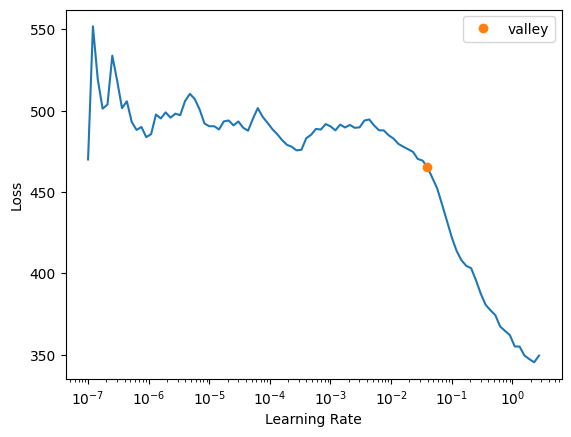

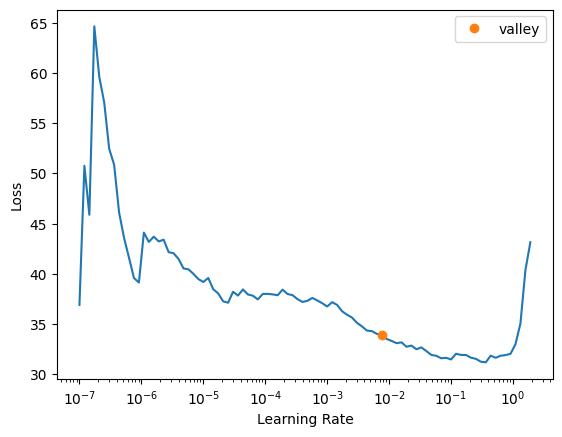

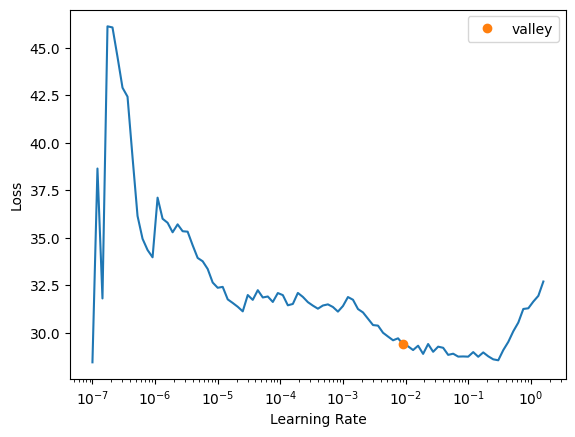

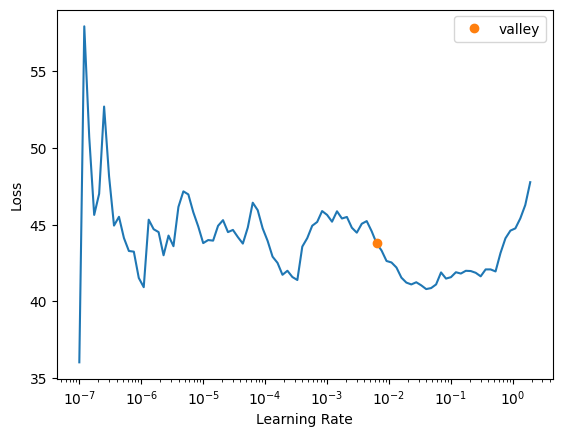

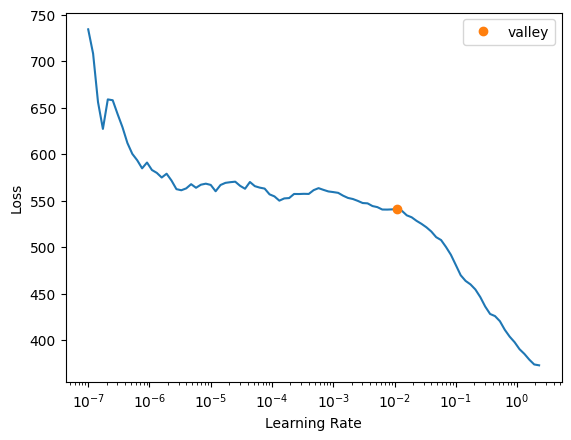

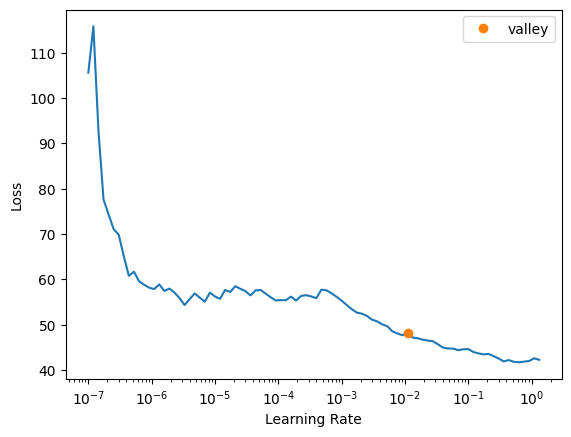

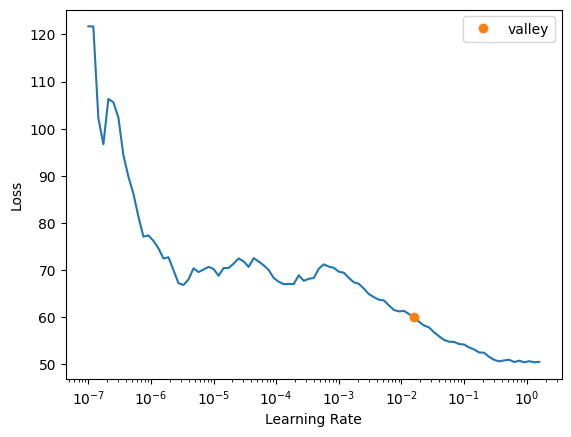

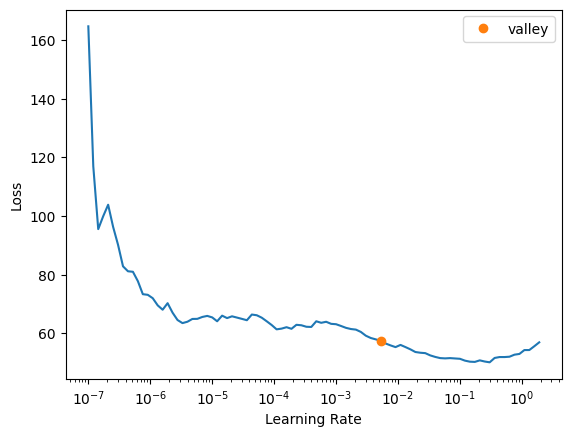

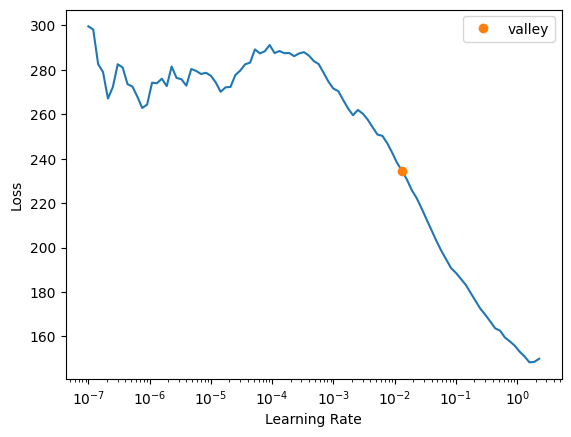

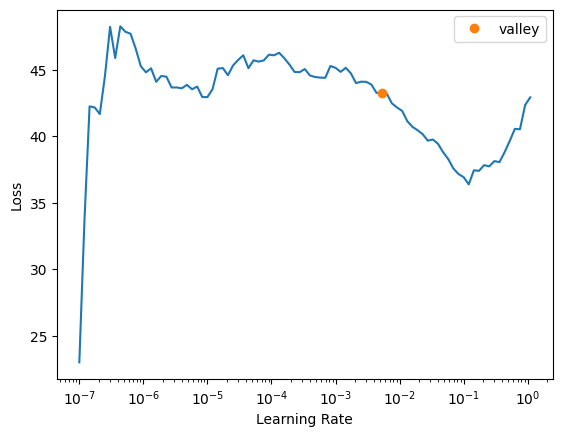

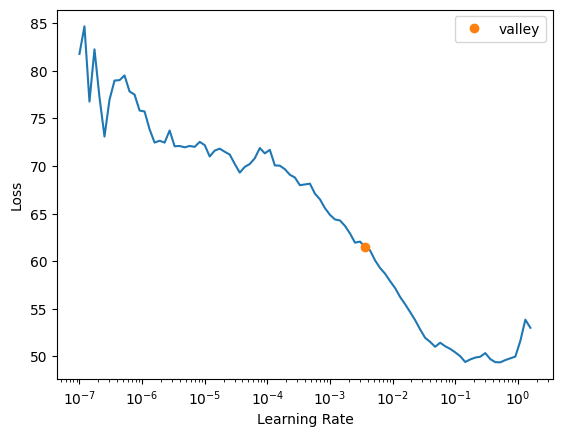

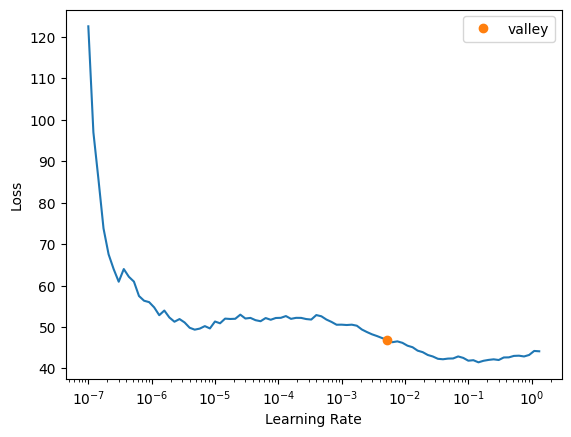

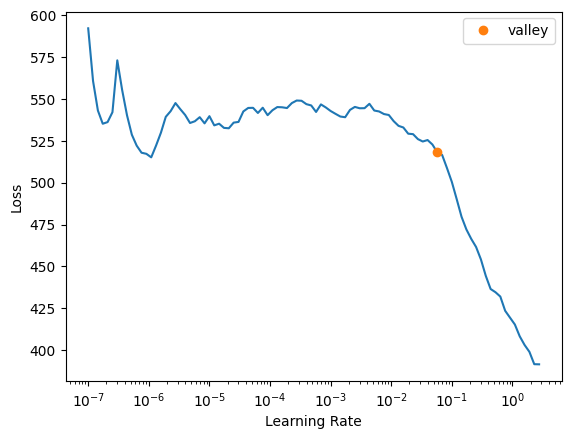

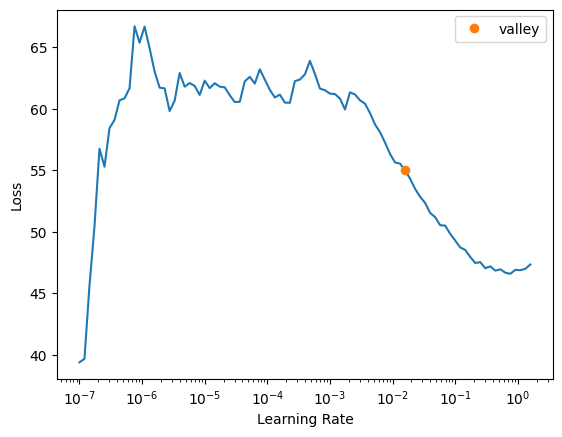

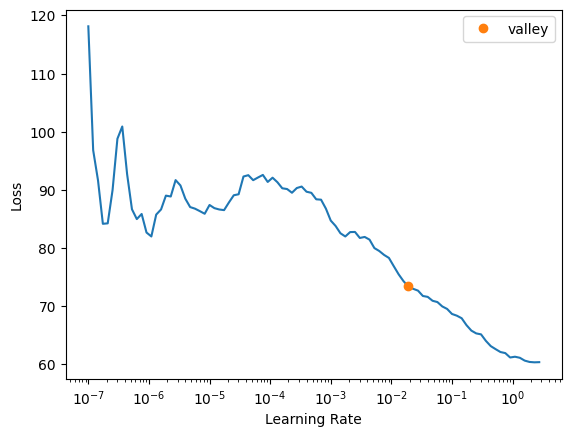

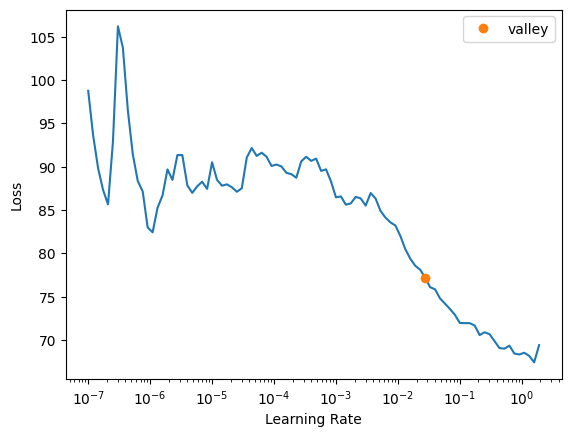

In [58]:
# Running SHADE algorithm with GD
results['SHADE-GD'] = {}
for layer in n_layers:
  start = time.perf_counter()
  results['SHADE-GD'][layer] = utilsTFG.SHADE_GD(copy.deepcopy(population[layer]), copy.deepcopy(fitness[layer]), max_evals, max_evals_shade, dls, mh_learners[layer], mh_learners[layer].model, task='reg')
  end = time.perf_counter()
  time_mh['SHADE-GD'][layer] = end-start


In [59]:
#Validation error
fitness_valid['SHADE-GD'] = {}
for layer in n_layers:
  fitness_valid['SHADE-GD'][layer] = []
  for ind in results['SHADE-GD'][layer][3]:
    fitness_valid['SHADE-GD'][layer].append(utilsTFG.err_param_valid(ind, mh_learners[layer].model, dls, task='reg'))

In [60]:
#Compare train and valid
for layer in n_layers:
  print(f"Training error of SHADE-GD for {layer} layers: {results['SHADE-GD'][layer][2]}")
  print(f"Validation error of SHADE-GD for {layer} layers: {fitness_valid['SHADE-GD'][layer]}")
  dif = np.array(fitness_valid['SHADE-GD'][layer]) - np.array(results['SHADE-GD'][layer][2])
  print(f"Difference: {dif}")
  #mejor = np.argmin(dif)
  mejor = np.argmin(fitness_valid['SHADE-GD'][layer])
  best['SHADE-GD'][layer] = results['SHADE-GD'][layer][3][mejor]
  print(f"Best generalizing model: Model {mejor+1} (1-10)")
  print("\n")

Training error of SHADE-GD for 1 layers: [504.3474426269531, 465.21966552734375, 464.57269287109375, 459.65234375, 453.9651184082031, 318.43359375, 33.18764114379883, 28.67128562927246, 28.67128562927246, 28.67128562927246, 28.67128562927246, 25.920654296875, 23.491329193115234, 23.491329193115234, 23.491329193115234, 23.491329193115234, 23.491329193115234, 23.491329193115234, 23.491329193115234, 23.491329193115234, 23.491329193115234, 23.491329193115234]
Validation error of SHADE-GD for 1 layers: [417.083740234375, 425.39263916015625, 409.2618408203125, 417.99078369140625, 426.6781921386719, 174.51780700683594, 96.88670349121094, 154.05337524414062, 154.05337524414062, 154.05337524414062, 154.05337524414062, 115.622802734375, 106.31671142578125, 106.31671142578125, 106.31671142578125, 106.31671142578125, 106.31671142578125, 106.31671142578125, 106.31671142578125, 106.31671142578125, 106.31671142578125, 106.31671142578125]
Difference: [ -87.26370239  -39.82702637  -55.31085205  -41.661

### SHADE-ILS-GD

deque([1, 1, 0.9324115719418868], maxlen=3)
eo
deque([1, 0.9324115719418868, 0.07189615954739369], maxlen=3)
deque([0.9324115719418868, 0.07189615954739369, -0.43827584333808745], maxlen=3)
deque([0.07189615954739369, -0.43827584333808745, 0.0], maxlen=3)
eo
deque([-0.43827584333808745, 0.0, 0.42331500139625194], maxlen=3)
deque([0.0, 0.42331500139625194, -0.4756097915541246], maxlen=3)
deque([0.42331500139625194, -0.4756097915541246, 0.0], maxlen=3)
eo
deque([-0.4756097915541246, 0.0, 0.30440440668241353], maxlen=3)
deque([0.0, 0.30440440668241353, -0.5469992606258741], maxlen=3)
deque([0.30440440668241353, -0.5469992606258741, 0.0], maxlen=3)
eo
deque([-0.5469992606258741, 0.0, 0.37393979620796675], maxlen=3)
deque([0.0, 0.37393979620796675, -0.5159520665162122], maxlen=3)
deque([0.37393979620796675, -0.5159520665162122, 0.0], maxlen=3)
eo
deque([-0.5159520665162122, 0.0, 0.3076832921179364], maxlen=3)
deque([0.0, 0.3076832921179364, -0.19256201352566377], maxlen=3)


Better model found at epoch 0 with valid_loss value: 26.8372802734375.
deque([0.3076832921179364, -0.19256201352566377, -0.20425643281464229], maxlen=3)
eo
deque([-0.19256201352566377, -0.20425643281464229, 0.417069286431878], maxlen=3)
deque([-0.20425643281464229, 0.417069286431878, -0.6506348660291293], maxlen=3)
deque([0.417069286431878, -0.6506348660291293, 0.0], maxlen=3)
eo
deque([-0.6506348660291293, 0.0, 0.3670783402127644], maxlen=3)
deque([0.0, 0.3670783402127644, -0.49483646667103703], maxlen=3)
deque([0.3670783402127644, -0.49483646667103703, 0.0], maxlen=3)
eo
deque([-0.49483646667103703, 0.0, 0.2612352192287026], maxlen=3)
deque([0.0, 0.2612352192287026, -0.23502320235151014], maxlen=3)
deque([0.2612352192287026, -0.23502320235151014, 0.0], maxlen=3)
eo
deque([-0.23502320235151014, 0.0, 0.18655780405898673], maxlen=3)
deque([0.0, 0.18655780405898673, -0.2924925352688265], maxlen=3)
deque([0.18655780405898673, -0.2924925352688265, 0.0], maxlen=3)
eo
deque([-0.2924925352688

Better model found at epoch 0 with valid_loss value: 28.462696075439453.
deque([0.2209750246194211, -0.20215472782638674, -0.11905340934542542], maxlen=3)
eo
deque([-0.20215472782638674, -0.11905340934542542, 0.2748598790577987], maxlen=3)
deque([-0.11905340934542542, 0.2748598790577987, -0.2324552067739521], maxlen=3)
deque([0.2748598790577987, -0.2324552067739521, 0.0], maxlen=3)
eo
deque([-0.2324552067739521, 0.0, 0.19232424415104027], maxlen=3)
deque([0.0, 0.19232424415104027, -0.32796731394532547], maxlen=3)
deque([0.19232424415104027, -0.32796731394532547, 0.0], maxlen=3)
eo
deque([-0.32796731394532547, 0.0, 0.24334522651456136], maxlen=3)
deque([0.0, 0.24334522651456136, -0.45504060669498725], maxlen=3)
deque([0.24334522651456136, -0.45504060669498725, 0.0], maxlen=3)
eo
deque([-0.45504060669498725, 0.0, 0.31181713904344144], maxlen=3)
deque([0.0, 0.31181713904344144, -0.4516299459160032], maxlen=3)
deque([0.31181713904344144, -0.4516299459160032, 0.0], maxlen=3)
eo
deque([-0.45

Better model found at epoch 0 with valid_loss value: 36.100982666015625.
deque([0.3103089925517323, -0.44865683283581004, 0.1558810969997789], maxlen=3)
eo
deque([-0.44865683283581004, 0.1558810969997789, 0.18139065298927756], maxlen=3)
deque([0.1558810969997789, 0.18139065298927756, -0.4463909222519014], maxlen=3)
deque([0.18139065298927756, -0.4463909222519014, 0.0], maxlen=3)
eo
deque([-0.4463909222519014, 0.0, 0.34752197398254686], maxlen=3)
deque([0.0, 0.34752197398254686, -0.38081749135688764], maxlen=3)
deque([0.34752197398254686, -0.38081749135688764, 0.0], maxlen=3)
eo
deque([-0.38081749135688764, 0.0, 0.2693102816609087], maxlen=3)
deque([0.0, 0.2693102816609087, 0.011293320570462397], maxlen=3)
deque([0.2693102816609087, 0.011293320570462397, 0.0], maxlen=3)
eo
deque([0.011293320570462397, 0.0, 0.0], maxlen=3)
deque([0.0, 0.0, 7.735290320529545e-08], maxlen=3)
deque([0.0, 7.735290320529545e-08, 0.0], maxlen=3)
Reiniciado
eo
deque([1, 1, 0.17174792615809817], maxlen=3)
deque(

Better model found at epoch 0 with valid_loss value: 33.53765106201172.
deque([0.17174792615809817, -0.5435043200833127, 0.04535107539243463], maxlen=3)
deque([1, 1, -0.05738197110791132], maxlen=3)
eo
deque([1, -0.05738197110791132, 0.03792579477303185], maxlen=3)
deque([-0.05738197110791132, 0.03792579477303185, 0.9260985016165353], maxlen=3)
deque([0.03792579477303185, 0.9260985016165353, 0.0], maxlen=3)
eo
deque([0.9260985016165353, 0.0, 0.2964775563237314], maxlen=3)
deque([0.0, 0.2964775563237314, -0.31219611507347933], maxlen=3)
deque([0.2964775563237314, -0.31219611507347933, 0.0], maxlen=3)
eo
deque([-0.31219611507347933, 0.0, 0.1919078702028325], maxlen=3)
deque([0.0, 0.1919078702028325, -0.24232061368740943], maxlen=3)
deque([0.1919078702028325, -0.24232061368740943, 0.0], maxlen=3)
eo
deque([-0.24232061368740943, 0.0, 0.1507844996347184], maxlen=3)
deque([0.0, 0.1507844996347184, -0.5793205806373459], maxlen=3)
deque([0.1507844996347184, -0.5793205806373459, 0.0], maxlen=3)

Better model found at epoch 0 with valid_loss value: 28.082799911499023.
deque([0.3748505362521414, -0.7122171168059208, 0.2562622526223889], maxlen=3)
eo
deque([-0.7122171168059208, 0.2562622526223889, 0.18519444628775408], maxlen=3)
deque([0.2562622526223889, 0.18519444628775408, -0.17535571515045598], maxlen=3)
deque([0.18519444628775408, -0.17535571515045598, 0.0], maxlen=3)
eo
deque([-0.17535571515045598, 0.0, 0.25004635960541227], maxlen=3)
deque([0.0, 0.25004635960541227, -0.42221294648199115], maxlen=3)
deque([0.25004635960541227, -0.42221294648199115, 0.0], maxlen=3)
eo
deque([-0.42221294648199115, 0.0, 0.3138319916941398], maxlen=3)
deque([0.0, 0.3138319916941398, -0.4628806099866198], maxlen=3)
deque([0.3138319916941398, -0.4628806099866198, 0.0], maxlen=3)
eo
deque([-0.4628806099866198, 0.0, 0.26625953038755434], maxlen=3)
deque([0.0, 0.26625953038755434, -0.3760955429796746], maxlen=3)
deque([0.26625953038755434, -0.3760955429796746, 0.0], maxlen=3)
eo
deque([-0.3760955429

Better model found at epoch 0 with valid_loss value: 21.34332847595215.
deque([0.2669164707590206, -0.5892208778292479, 0.13977365697316999], maxlen=3)
eo
deque([-0.5892208778292479, 0.13977365697316999, 0.279612737837874], maxlen=3)
deque([0.13977365697316999, 0.279612737837874, -0.21323410957632524], maxlen=3)
deque([0.279612737837874, -0.21323410957632524, 0.0], maxlen=3)
eo
deque([-0.21323410957632524, 0.0, 0.1307465166820532], maxlen=3)
deque([0.0, 0.1307465166820532, -0.06922171777589925], maxlen=3)
deque([0.1307465166820532, -0.06922171777589925, 0.0], maxlen=3)
eo
deque([-0.06922171777589925, 0.0, 0.06941477925703729], maxlen=3)
deque([0.0, 0.06941477925703729, -0.30246940574874653], maxlen=3)
deque([0.06941477925703729, -0.30246940574874653, 0.0], maxlen=3)
eo
deque([-0.30246940574874653, 0.0, 0.23368213700389467], maxlen=3)
deque([0.0, 0.23368213700389467, -0.2584857863694785], maxlen=3)
deque([0.23368213700389467, -0.2584857863694785, 0.0], maxlen=3)
eo
deque([-0.25848578636

Better model found at epoch 0 with valid_loss value: 42.71237564086914.
deque([0.22466406842704956, -0.16203175647765822, -0.11806475290612464], maxlen=3)
eo
deque([-0.16203175647765822, -0.11806475290612464, 0.3175111157819578], maxlen=3)
deque([-0.11806475290612464, 0.3175111157819578, -0.35305436779634136], maxlen=3)
deque([0.3175111157819578, -0.35305436779634136, 0.0], maxlen=3)
eo
deque([-0.35305436779634136, 0.0, 0.264757960491173], maxlen=3)
deque([0.0, 0.264757960491173, -0.38287340127945807], maxlen=3)
deque([0.264757960491173, -0.38287340127945807, 0.0], maxlen=3)
eo
deque([-0.38287340127945807, 0.0, 0.2809257238819508], maxlen=3)
deque([0.0, 0.2809257238819508, -0.3952332719790445], maxlen=3)
deque([0.2809257238819508, -0.3952332719790445, 0.0], maxlen=3)
eo
deque([-0.3952332719790445, 0.0, 0.2893591974582939], maxlen=3)
deque([0.0, 0.2893591974582939, -0.40320409829189546], maxlen=3)
deque([0.2893591974582939, -0.40320409829189546, 0.0], maxlen=3)
eo
deque([-0.403204098291

Better model found at epoch 0 with valid_loss value: 33.28031921386719.
deque([0.2919919108318792, -0.41162379627031365, 0.1788838767083667], maxlen=3)
deque([1, 1, 0.9512480581316378], maxlen=3)
eo
deque([1, 0.9512480581316378, 0.0], maxlen=3)
deque([0.9512480581316378, 0.0, -0.2400405728700451], maxlen=3)
deque([0.0, -0.2400405728700451, 0.0], maxlen=3)
Reiniciado
eo
deque([1, 1, 0.1864992535703913], maxlen=3)
deque([1, 0.1864992535703913, 0.3937194508459732], maxlen=3)
deque([0.1864992535703913, 0.3937194508459732, 0.0], maxlen=3)
eo
deque([0.3937194508459732, 0.0, 0.06444968968431225], maxlen=3)
deque([0.0, 0.06444968968431225, -0.6955119043071721], maxlen=3)
deque([0.06444968968431225, -0.6955119043071721, 0.0], maxlen=3)
eo
deque([-0.6955119043071721, 0.0, 0.22382937720569082], maxlen=3)
deque([0.0, 0.22382937720569082, 0.30155124011328804], maxlen=3)
deque([0.22382937720569082, 0.30155124011328804, 0.0], maxlen=3)
eo
deque([0.30155124011328804, 0.0, 0.025088520317959245], maxlen

Better model found at epoch 0 with valid_loss value: 30.293569564819336.
deque([0.025088520317959245, 0.12937704723004748, -0.8814502624761579], maxlen=3)
eo
deque([0.12937704723004748, -0.8814502624761579, 0.4684951178651356], maxlen=3)
deque([-0.8814502624761579, 0.4684951178651356, -0.06446285190957787], maxlen=3)
deque([0.4684951178651356, -0.06446285190957787, 0.0], maxlen=3)
eo
deque([-0.06446285190957787, 0.0, 0.2138118876463491], maxlen=3)
deque([0.0, 0.2138118876463491, -0.3972243144232582], maxlen=3)
deque([0.2138118876463491, -0.3972243144232582, 0.0], maxlen=3)
eo
deque([-0.3972243144232582, 0.0, 0.1977374634028111], maxlen=3)
deque([0.0, 0.1977374634028111, -0.28233742882119744], maxlen=3)
deque([0.1977374634028111, -0.28233742882119744, 0.0], maxlen=3)
eo
deque([-0.28233742882119744, 0.0, 0.2570549420040847], maxlen=3)
deque([0.0, 0.2570549420040847, -0.418083692317458], maxlen=3)
deque([0.2570549420040847, -0.418083692317458, 0.0], maxlen=3)
eo
deque([-0.418083692317458,

Better model found at epoch 0 with valid_loss value: 30.451969146728516.
deque([0.10076914625942653, 0.038796399791405804, -0.4219660350614896], maxlen=3)
eo
deque([0.038796399791405804, -0.4219660350614896, 0.350037496643037], maxlen=3)
deque([-0.4219660350614896, 0.350037496643037, -0.19527176889509104], maxlen=3)
deque([0.350037496643037, -0.19527176889509104, 0.0], maxlen=3)
eo
deque([-0.19527176889509104, 0.0, 0.1031340211312691], maxlen=3)
deque([0.0, 0.1031340211312691, 0.10831255394648509], maxlen=3)
deque([0.1031340211312691, 0.10831255394648509, 0.0], maxlen=3)
eo
deque([0.10831255394648509, 0.0, 0.00045589535777463424], maxlen=3)
deque([0.0, 0.00045589535777463424, -0.13765892219636397], maxlen=3)
deque([0.00045589535777463424, -0.13765892219636397, 0.0], maxlen=3)
Reiniciado
eo
deque([1, 1, 0.2270678353674112], maxlen=3)
deque([1, 0.2270678353674112, 0.20004809566079318], maxlen=3)
deque([0.2270678353674112, 0.20004809566079318, 0.0], maxlen=3)
eo
deque([0.20004809566079318

Better model found at epoch 0 with valid_loss value: 33.432167053222656.
deque([0.04346454997048235, 0.19654993400639897, -0.3216949086942943], maxlen=3)
eo
deque([0.19654993400639897, -0.3216949086942943, 0.32639100859947806], maxlen=3)
deque([-0.3216949086942943, 0.32639100859947806, 0.08951326479865768], maxlen=3)
deque([0.32639100859947806, 0.08951326479865768, 0.0], maxlen=3)
eo
deque([0.08951326479865768, 0.0, 0.17629173805119439], maxlen=3)
deque([0.0, 0.17629173805119439, -0.33191980996599724], maxlen=3)
deque([0.17629173805119439, -0.33191980996599724, 0.0], maxlen=3)
eo
deque([-0.33191980996599724, 0.0, 0.22738738370264466], maxlen=3)
deque([0.0, 0.22738738370264466, -0.5258961517456306], maxlen=3)
deque([0.22738738370264466, -0.5258961517456306, 0.0], maxlen=3)
eo
deque([-0.5258961517456306, 0.0, 0.330826470475641], maxlen=3)
deque([0.0, 0.330826470475641, -0.5347577736927706], maxlen=3)
deque([0.330826470475641, -0.5347577736927706, 0.0], maxlen=3)
eo
deque([-0.534757773692

Better model found at epoch 0 with valid_loss value: 28.316375732421875.
deque([0.35187640134575787, -0.39469519281977333, 0.26508709878375025], maxlen=3)
deque([1, 1, -0.014205950396948424], maxlen=3)
eo
deque([1, -0.014205950396948424, 0.09845191048583904], maxlen=3)
deque([-0.014205950396948424, 0.09845191048583904, -0.07248627918903562], maxlen=3)
deque([0.09845191048583904, -0.07248627918903562, 0.0], maxlen=3)
eo
deque([-0.07248627918903562, 0.0, 0.10896545302900873], maxlen=3)
deque([0.0, 0.10896545302900873, 0.9070406810447601], maxlen=3)
deque([0.10896545302900873, 0.9070406810447601, 0.0], maxlen=3)
eo
deque([0.9070406810447601, 0.0, 0.21101153936658854], maxlen=3)
deque([0.0, 0.21101153936658854, 0.009098066702546837], maxlen=3)
deque([0.21101153936658854, 0.009098066702546837, 0.0], maxlen=3)
eo
deque([0.009098066702546837, 0.0, 0.14422575258540807], maxlen=3)
deque([0.0, 0.14422575258540807, -0.21526429460243773], maxlen=3)
deque([0.14422575258540807, -0.21526429460243773,

Better model found at epoch 0 with valid_loss value: 42.374107360839844.
deque([0.04186577633337158, -0.2292555210440003, -0.17666928005363092], maxlen=3)
Reiniciado
eo
deque([1, 1, 0.5207579444832661], maxlen=3)
deque([1, 0.5207579444832661, -0.4329363122178456], maxlen=3)
deque([0.5207579444832661, -0.4329363122178456, 0.0], maxlen=3)
eo
deque([-0.4329363122178456, 0.0, 0.35381678239553294], maxlen=3)
deque([0.0, 0.35381678239553294, -0.4752021831769922], maxlen=3)
deque([0.35381678239553294, -0.4752021831769922, 0.0], maxlen=3)
eo
deque([-0.4752021831769922, 0.0, 0.28220606834907463], maxlen=3)
deque([0.0, 0.28220606834907463, -0.5462550790887243], maxlen=3)
deque([0.28220606834907463, -0.5462550790887243, 0.0], maxlen=3)
eo
deque([-0.5462550790887243, 0.0, 0.3948889606882172], maxlen=3)
deque([0.0, 0.3948889606882172, -0.6268065193037718], maxlen=3)
deque([0.3948889606882172, -0.6268065193037718, 0.0], maxlen=3)
eo
deque([-0.6268065193037718, 0.0, 0.41510954714265796], maxlen=3)
de

Better model found at epoch 0 with valid_loss value: 46.31084060668945.
deque([0.41510954714265796, -0.7556067711405354, 0.3485800586568684], maxlen=3)
eo
deque([-0.7556067711405354, 0.3485800586568684, 0.35114667659308335], maxlen=3)
deque([0.3485800586568684, 0.35114667659308335, -0.25709045516115714], maxlen=3)
deque([0.35114667659308335, -0.25709045516115714, 0.0], maxlen=3)
eo
deque([-0.25709045516115714, 0.0, 0.06197329030098926], maxlen=3)
deque([0.0, 0.06197329030098926, -0.03596625688358183], maxlen=3)
deque([0.06197329030098926, -0.03596625688358183, 0.0], maxlen=3)
eo
deque([-0.03596625688358183, 0.0, 0.11243784603114317], maxlen=3)
deque([0.0, 0.11243784603114317, -0.3978568653192433], maxlen=3)
deque([0.11243784603114317, -0.3978568653192433, 0.0], maxlen=3)
eo
deque([-0.3978568653192433, 0.0, 0.22597055079003867], maxlen=3)
deque([0.0, 0.22597055079003867, -0.9514648599421304], maxlen=3)
deque([0.22597055079003867, -0.9514648599421304, 0.0], maxlen=3)
eo
deque([-0.9514648

Better model found at epoch 0 with valid_loss value: 33.06623840332031.
deque([0.48024848941342757, -0.37670998877681944, 0.2534444368584665], maxlen=3)
eo
deque([-0.37670998877681944, 0.2534444368584665, 0.21371196352165625], maxlen=3)
deque([0.2534444368584665, 0.21371196352165625, -0.218488843303044], maxlen=3)
deque([0.21371196352165625, -0.218488843303044, 0.0], maxlen=3)
eo
deque([-0.218488843303044, 0.0, 0.16845517043890737], maxlen=3)
deque([0.0, 0.16845517043890737, -0.6309676536799627], maxlen=3)
deque([0.16845517043890737, -0.6309676536799627, 0.0], maxlen=3)
eo
deque([-0.6309676536799627, 0.0, 0.39513540755370774], maxlen=3)
deque([0.0, 0.39513540755370774, -0.551024525900352], maxlen=3)
deque([0.39513540755370774, -0.551024525900352, 0.0], maxlen=3)
eo
deque([-0.551024525900352, 0.0, 0.19565880448424008], maxlen=3)
deque([0.0, 0.19565880448424008, -0.6446922293294054], maxlen=3)
deque([0.19565880448424008, -0.6446922293294054, 0.0], maxlen=3)
eo
deque([-0.6446922293294054,

Better model found at epoch 0 with valid_loss value: 31.653026580810547.
deque([0.41358420094482556, -0.7244496963345102, 0.3231817713833375], maxlen=3)


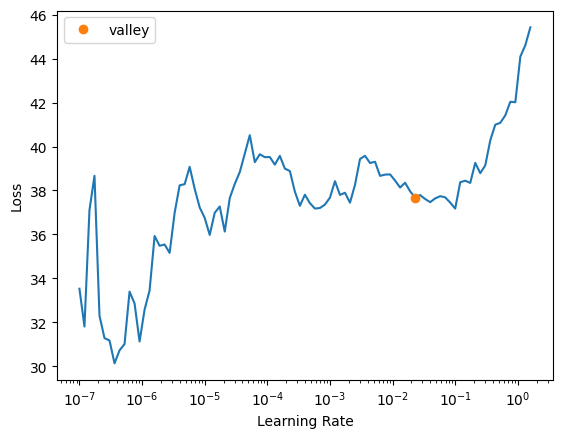

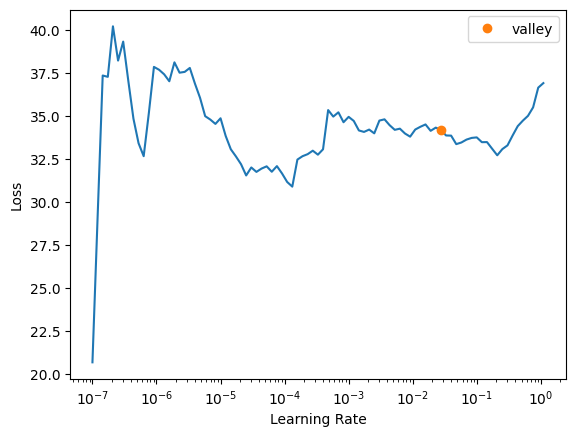

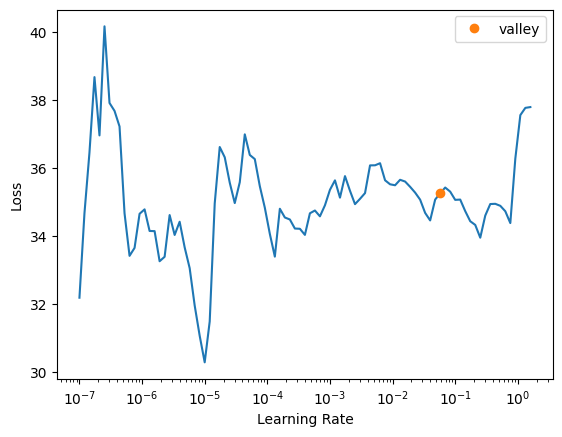

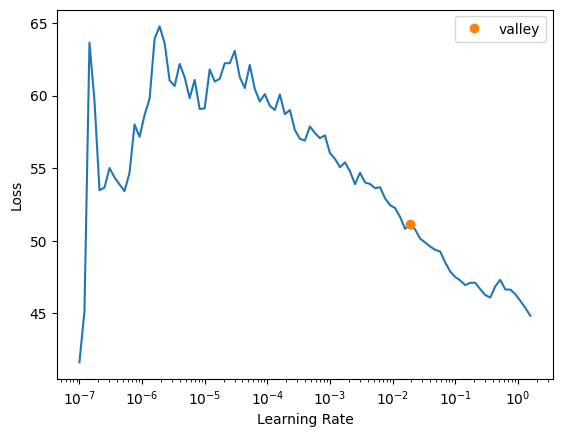

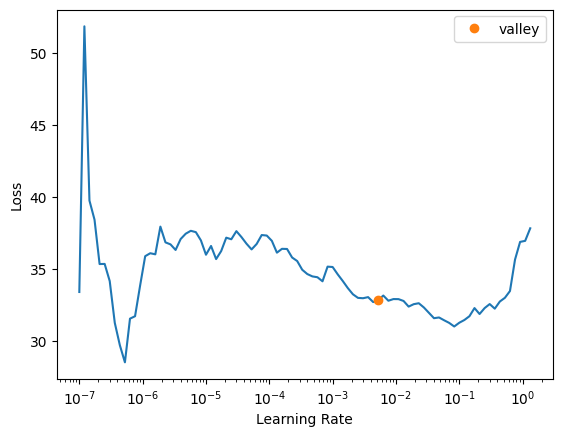

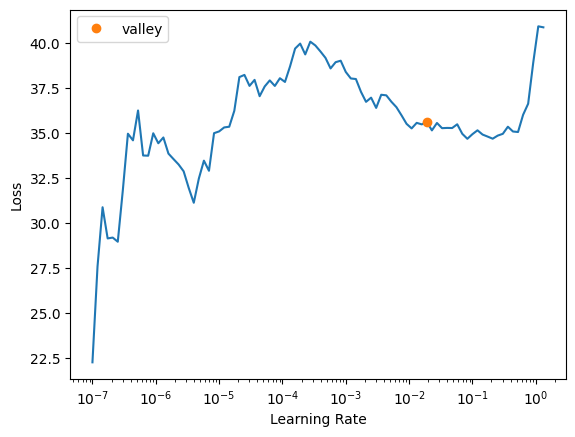

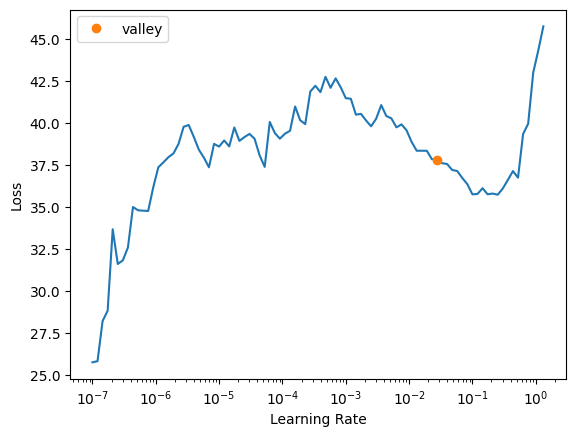

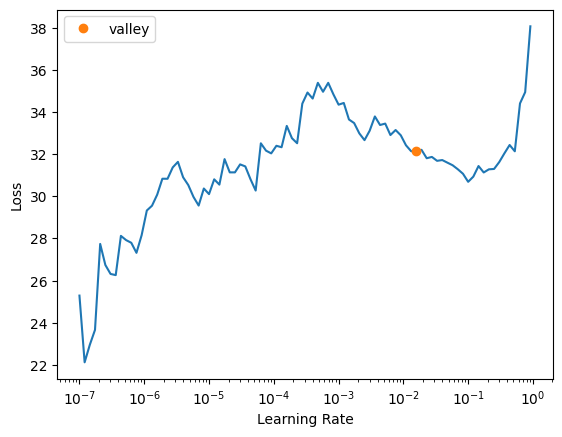

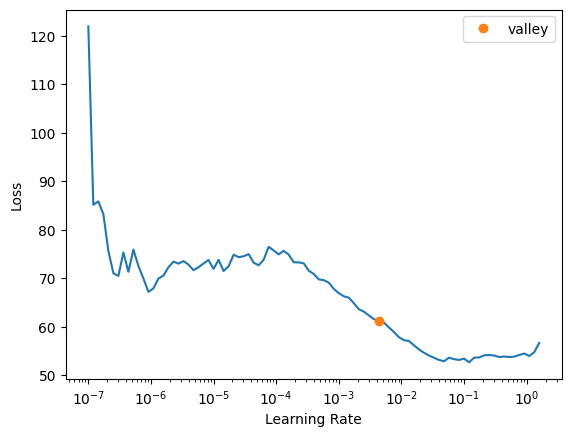

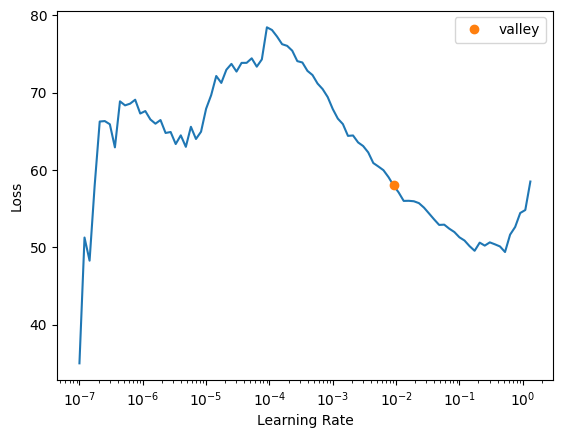

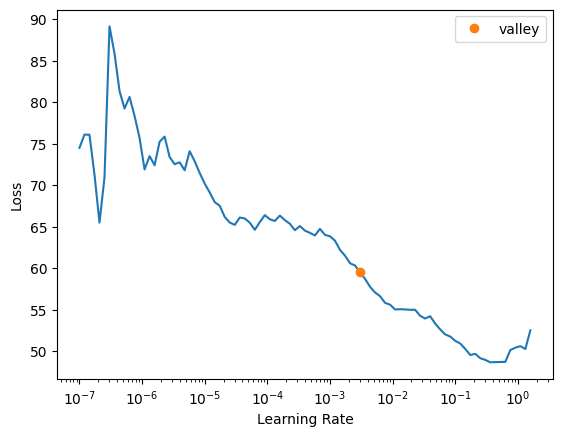

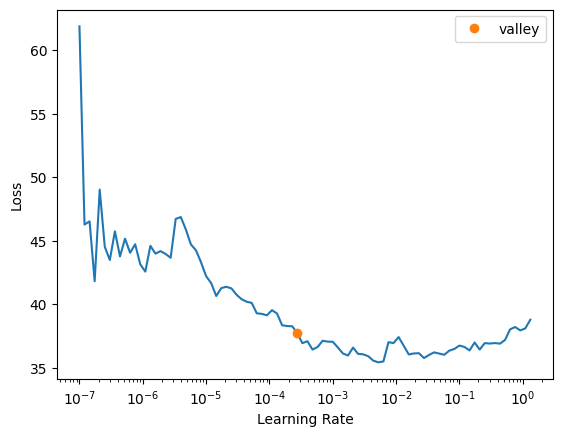

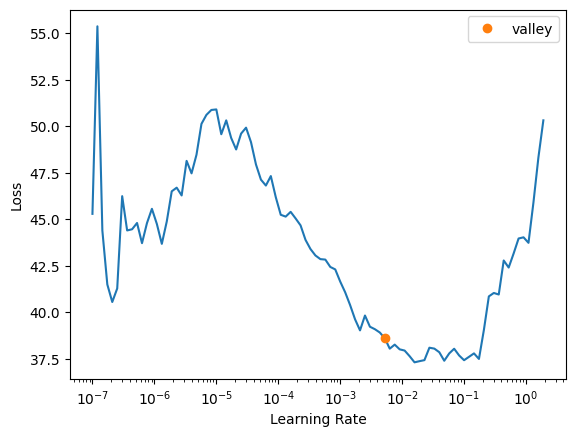

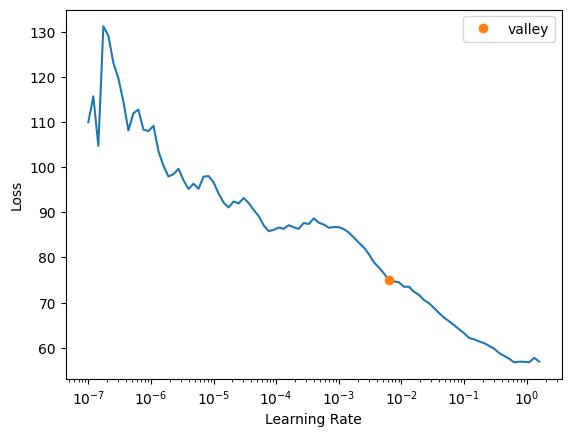

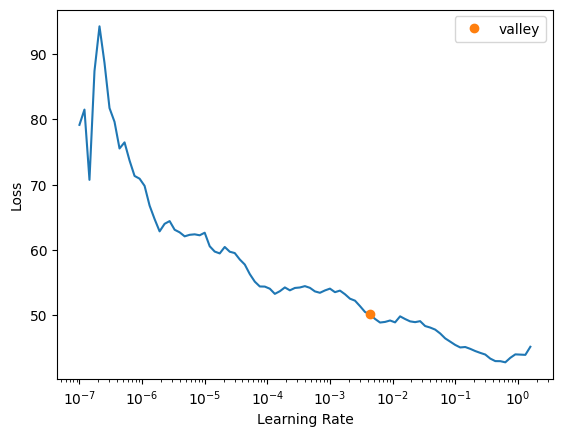

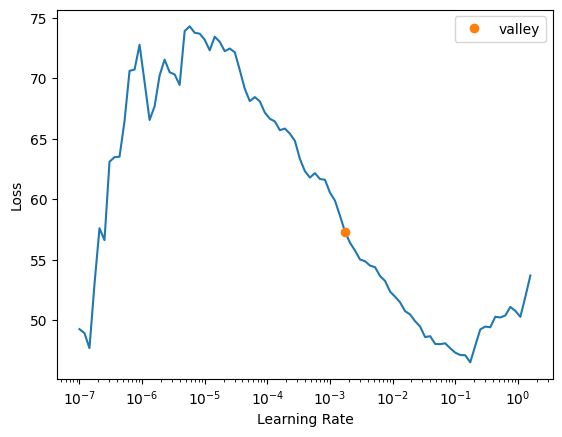

In [61]:
# Working ???
results['SHADE-ILS-GD'] = {}
for layer in n_layers:
  start = time.perf_counter()
  results['SHADE-ILS-GD'][layer] = utilsTFG.SHADE_ILS_GD(copy.deepcopy(population[layer]), copy.deepcopy(fitness[layer]),  max_evals, max_evals_shade, dls, mh_learners[layer], mh_learners[layer].model, max_ls=max_ls, task='reg')
  end = time.perf_counter()
  time_mh['SHADE-ILS-GD'][layer] = end-start


In [62]:
#Validation error
fitness_valid['SHADE-ILS-GD'] = {}
for layer in n_layers:
  fitness_valid['SHADE-ILS-GD'][layer] = []
  for ind in results['SHADE-ILS-GD'][layer][3]:
    fitness_valid['SHADE-ILS-GD'][layer].append(utilsTFG.err_param_valid(ind, mh_learners[layer].model, dls, task='reg'))

In [63]:
#Compare train and valid
for layer in n_layers:
  print(f"Training error of SHADE-ILS-GD for {layer} layers: {results['SHADE-ILS-GD'][layer][2]}")
  print(f"Validation error of SHADE-ILS-GD for {layer} layers: {fitness_valid['SHADE-ILS-GD'][layer]}")
  dif = np.array(fitness_valid['SHADE-ILS-GD'][layer]) - np.array(results['SHADE-ILS-GD'][layer][2])
  print(f"Difference: {dif}")
  mejor = np.argmin(fitness_valid['SHADE-ILS-GD'][layer])
  best['SHADE-ILS-GD'][layer] = results['SHADE-ILS-GD'][layer][3][mejor]
  print(f"Best generalizing model: Model {mejor+1} (1-10)")
  print("\n")

Training error of SHADE-ILS-GD for 1 layers: [504.3474426269531, 34.088050842285156, 45.50309371948242, 38.721405029296875, 38.721405029296875, 38.721405029296875, 38.721405029296875, 37.833133697509766, 35.794471740722656, 32.65857696533203, 32.65857696533203, 32.65857696533203, 32.15937805175781, 32.15937805175781, 32.15937805175781, 32.15937805175781, 31.995466232299805, 31.995466232299805, 31.995466232299805, 24.657751083374023, 24.65774917602539, 24.65774917602539]
Validation error of SHADE-ILS-GD for 1 layers: [437.7420654296875, 27.344036102294922, 22.977602005004883, 42.37986755371094, 42.37986755371094, 42.37986755371094, 42.37986755371094, 26.605985641479492, 28.037242889404297, 23.896020889282227, 23.896020889282227, 23.896020889282227, 40.530235290527344, 40.530235290527344, 40.530235290527344, 40.530235290527344, 72.1346206665039, 72.1346206665039, 72.1346206665039, 83.56773376464844, 83.56773376464844, 83.56773376464844]
Difference: [-66.6053772   -6.74401474 -22.52549171

### Save or load

In [72]:
#Save the mh results
file_path = f'/notebooks/saved_models/mh_dict_{dataset}.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(results, f)

In [65]:
#Load the trained mh results
#file_path = f'/notebooks/saved_models/mh_dict_{dataset}.pkl'
#with open(file_path, 'rb') as f:
#    results = pickle.load(f)

### Comparison between MH

In [73]:
#Saving training loss for better manipulation
training = {}
for mh in algs:
  training[mh] = {}
for layer in n_layers:
  training['SHADE'][layer] = results['SHADE'][layer][6]
  training['SHADE-ILS'][layer] = results['SHADE-ILS'][layer][2]
  training['SHADE-GD'][layer] = results['SHADE-GD'][layer][2]
  training['SHADE-ILS-GD'][layer] = results['SHADE-ILS-GD'][layer][2]

In [74]:
#Calculate r2sq
r2sq = {}
#f1score = {}
for mh in algs:
  #f1score[mh] = {}
  r2sq[mh] = {}
  for layer in n_layers:
    #1score[mh][layer] = []
    r2sq[mh][layer] = []
    ind = 5 if mh == 'SHADE' else 3
    for model in results[mh][layer][ind]:
      utilsTFG.set_params_to_model(model, mh_learners[layer].model)
      mh_learners[layer].model.eval()
      mh_learners[layer].eval()
      preds, targs = mh_learners[layer].get_preds(dl=dls.valid)
      targs = targs.long().squeeze()

      # Calculate balanced_accuracy
      r2sq[mh][layer].append(utilsTFG.adjusted_r2_score(preds, targs))

      # Calculate F1-Score
      #f1score[mh][layer].append(utilsTFG.f1_score_func(preds, targs))

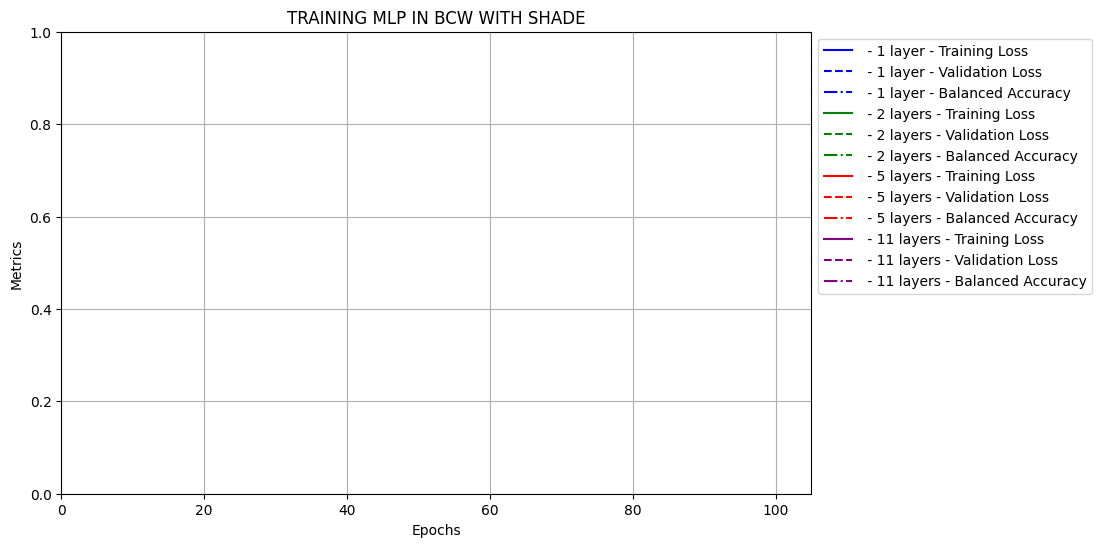

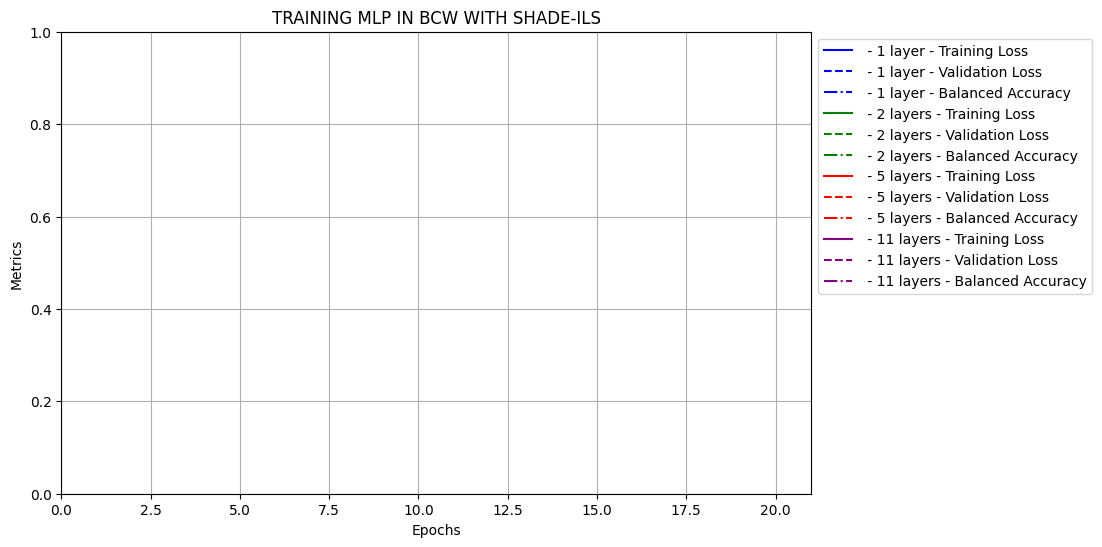

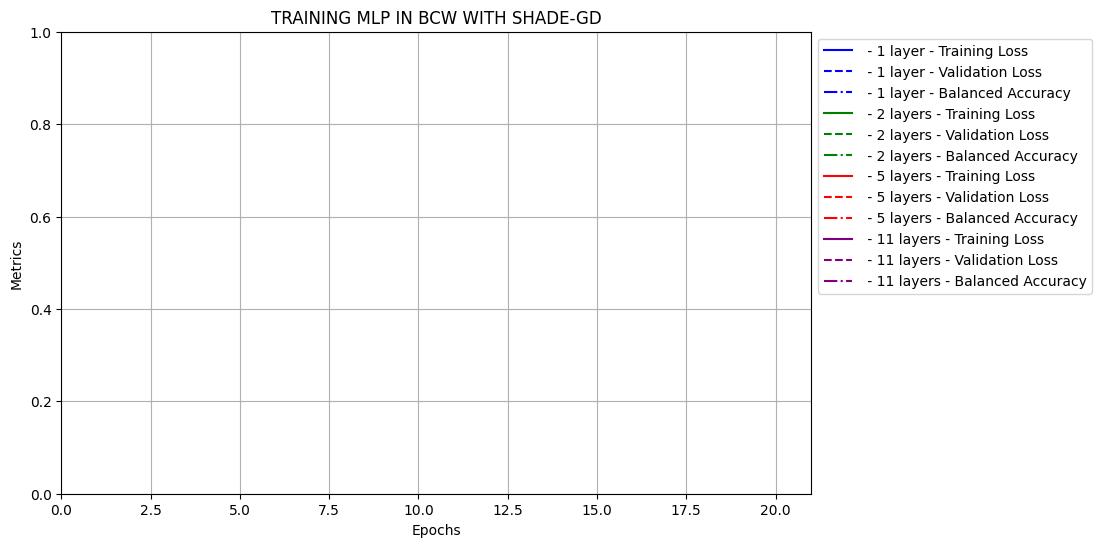

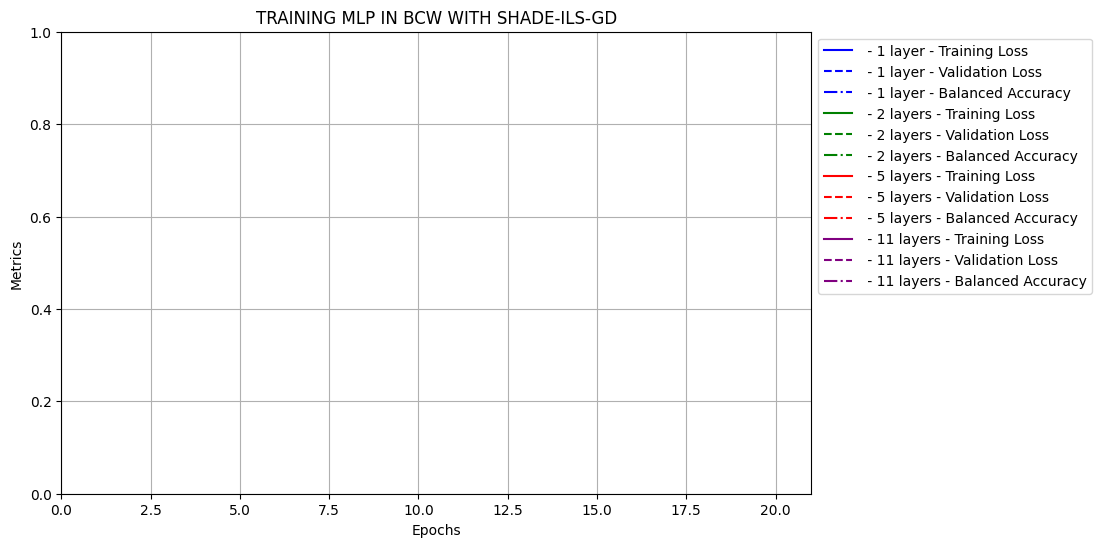

In [75]:
#Comparing the different layers version of the same MH
names= ['1 layer', '2 layers', '5 layers', '11 layers']
for alg in algs:
  utilsTFG.plot_mh_mlp_training(training[alg], fitness_valid[alg], r2sq[alg],  layers = n_layers, names=names, title=f'TRAINING MLP IN BCW WITH {alg}')

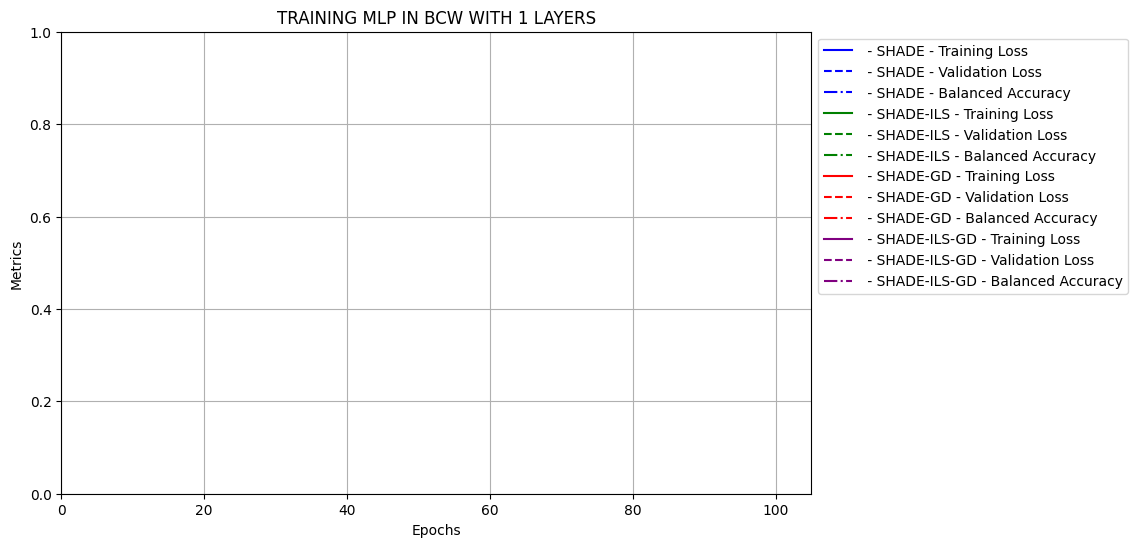

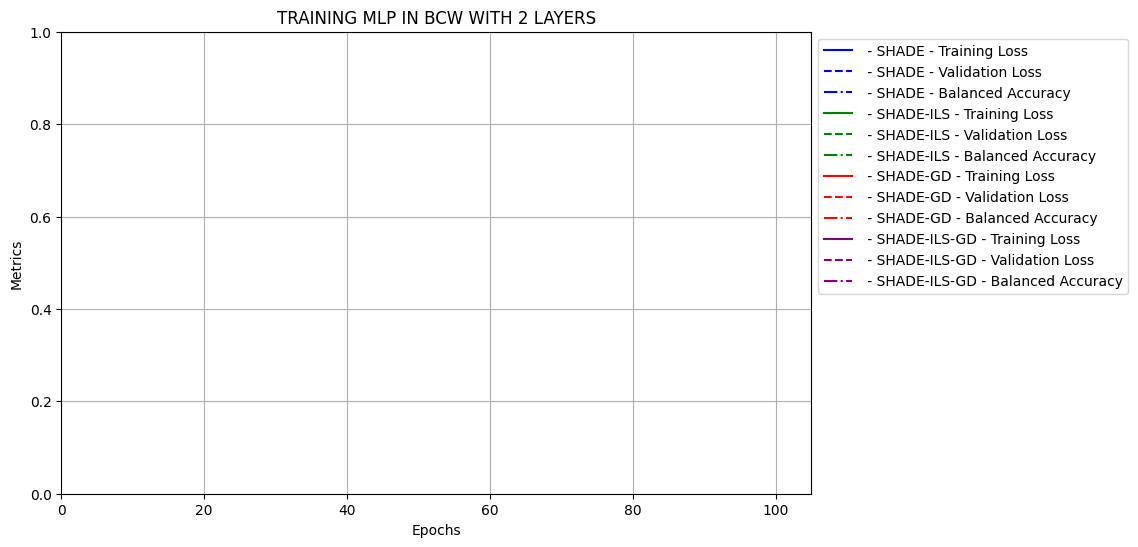

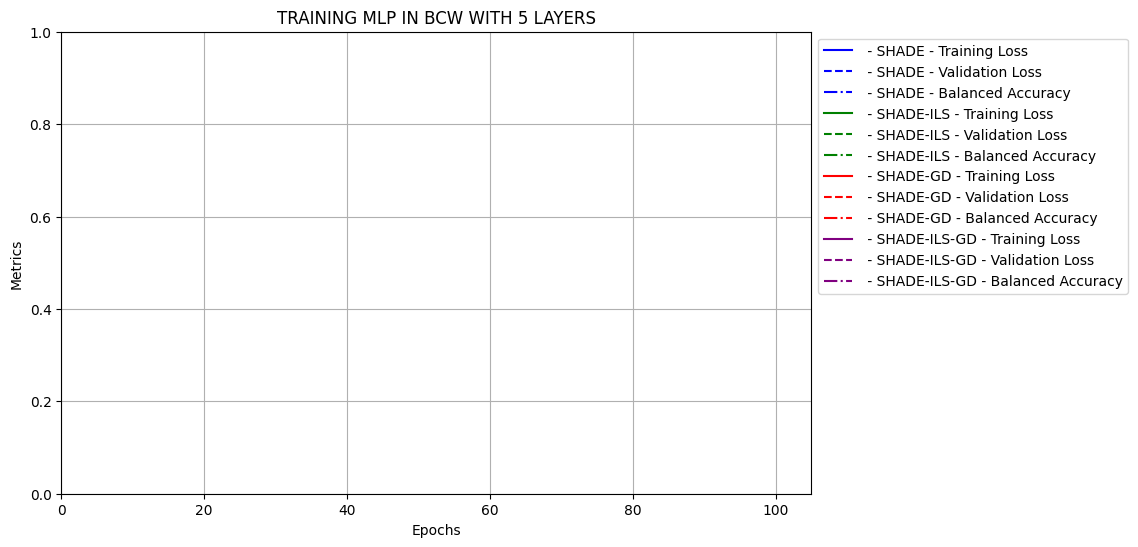

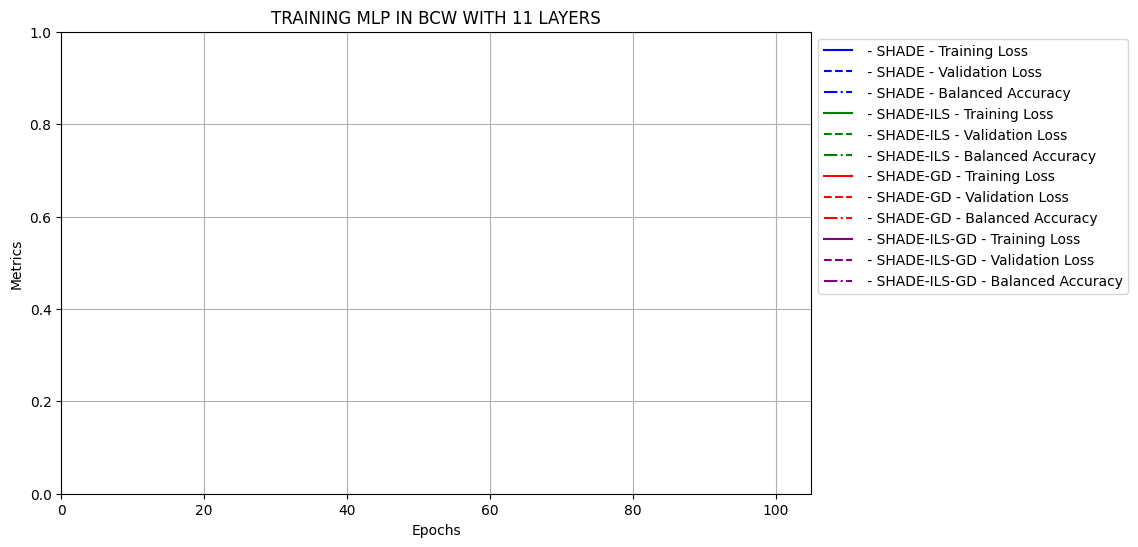

In [76]:
#Comparing the different MH for the same layer number

names= ['SHADE', 'SHADE-ILS', 'SHADE-GD', 'SHADE-ILS-GD']
train = {}
r2 = {}
valid = {}
for layer in n_layers:
  train[layer] = {}
  r2[layer] = {}
  valid[layer] = {}
  for alg in algs:
    train[layer][alg] = training[alg][layer]
    r2[layer][alg] = r2sq[alg][layer]
    valid[layer][alg] = fitness_valid[alg][layer]
  utilsTFG.plot_mh_mlp_training(train[layer], valid[layer], r2[layer], layers = names, names=names, title=f'TRAINING MLP IN BCW WITH {layer} LAYERS')

### Generalization

In [79]:
#Run the model in the test set
for mh in algs:
  for layer in n_layers:
    #Run the model with optimizer optim and n_layers layer the test set in evaluation mode
    utilsTFG.set_params_to_model(best[mh][layer], mh_learners[layer].model)
    mh_learners[layer].model.eval()
    mh_learners[layer].eval()
    preds, targs = mh_learners[layer].get_preds(dl=test_dl)
    targs = targs.long().squeeze()

    #Calculate balanced accuracy

    ac = utilsTFG.adjusted_r2_score(preds, targs)

    #Calculate F1-Score
    #f1 = utilsTFG.f1_score_func(preds, targs)

    loss = utilsTFG.err_param_w_model(mh_learners[layer].model, test_dl, mode = 'test', task='reg')

    print(f"Optimizer: {mh}, Layers: {layer}, Loss: {loss}, R2 Square: {ac}")

Optimizer: SHADE, Layers: 1, Loss: 408.01934814453125, R2 Square: -209.0016220192512


Optimizer: SHADE, Layers: 2, Loss: 438.9460144042969, R2 Square: -485.2478200565714


Optimizer: SHADE, Layers: 5, Loss: 497.97198486328125, R2 Square: -95674.64567034577


Optimizer: SHADE, Layers: 11, Loss: 528.11767578125, R2 Square: -9558827434821.137


Optimizer: SHADE-ILS, Layers: 1, Loss: 23.402746200561523, R2 Square: -3.642928161326852


Optimizer: SHADE-ILS, Layers: 2, Loss: 38.16728210449219, R2 Square: -0.14835162165107052


Optimizer: SHADE-ILS, Layers: 5, Loss: 28.814960479736328, R2 Square: -1379.3362481410916


Optimizer: SHADE-ILS, Layers: 11, Loss: 22.924633026123047, R2 Square: -5042155454.191505


Optimizer: SHADE-GD, Layers: 1, Loss: 314.1727294921875, R2 Square: -3.0704286564311722


Optimizer: SHADE-GD, Layers: 2, Loss: 11006.572265625, R2 Square: -1.685281976452249


Optimizer: SHADE-GD, Layers: 5, Loss: 453.976806640625, R2 Square: -6597.771154193859


Optimizer: SHADE-GD, Layers: 11, Loss: 44026876.0, R2 Square: -0.21000312212289596


Optimizer: SHADE-ILS-GD, Layers: 1, Loss: 24.9410457611084, R2 Square: -3.2241413818620197


Optimizer: SHADE-ILS-GD, Layers: 2, Loss: 23.355131149291992, R2 Square: -2.7959524335720167


Optimizer: SHADE-ILS-GD, Layers: 5, Loss: 24.72682762145996, R2 Square: -2221.2940841296904


Optimizer: SHADE-ILS-GD, Layers: 11, Loss: 22.924633026123047, R2 Square: -5042155454.191505


## Time comparison

In [71]:
#Compare times for each algorithm and layer

#GD
for alg, time_layers in time_mh.items():
  for layer, time in time_layers.items():
    print(f'Time consumed by {alg} training with {layer} layers: {time:.04f} seconds')

#MH
for optims, time_layers in time_gd.items():
  for layer, time in time_layers.items():
    print(f'Time consumed by {optims} training with {layer} layers: {time:.04f} seconds')



Time consumed by SHADE training with 1 layers: 102.1612 seconds
Time consumed by SHADE training with 2 layers: 113.7708 seconds
Time consumed by SHADE training with 5 layers: 167.4802 seconds
Time consumed by SHADE training with 11 layers: 848.7978 seconds
Time consumed by SHADE-ILS training with 1 layers: 111.6120 seconds
Time consumed by SHADE-ILS training with 2 layers: 115.7318 seconds
Time consumed by SHADE-ILS training with 5 layers: 190.5461 seconds
Time consumed by SHADE-ILS training with 11 layers: 933.2237 seconds
Time consumed by SHADE-GD training with 1 layers: 109.9428 seconds
Time consumed by SHADE-GD training with 2 layers: 124.7065 seconds
Time consumed by SHADE-GD training with 5 layers: 178.6685 seconds
Time consumed by SHADE-GD training with 11 layers: 866.3289 seconds
Time consumed by SHADE-ILS-GD training with 1 layers: 111.4127 seconds
Time consumed by SHADE-ILS-GD training with 2 layers: 124.7688 seconds
Time consumed by SHADE-ILS-GD training with 5 layers: 198.6